#CIS545 Group Project <br>
## Train Delay Analysis and Prediction using Weather Data
By Dhruv Gupta and Vasanth Kolli <br>
Dec 15th, 2022

# Motivation

Our idea is to analyze the correlation between weather data and train delays in the New Jersey region and further evaluate if the correlation (if any) can be leveraged to predict the train delays based on weather information. We hypothesize that the adversarial weather significantly impacts the train delays. Although, there are other factors which cause the delay like track maintenance, technical failures etc, we are looking to test the more specific hypothesis of weather-delay correlations.

The above involves integrating the train delay and weather data. Eventually, we wish to build various regression models(linear regression, decision trees and neural nets) that can accurately predict delays based on features such as train, stops, time of day, and the weather forecast.

The novelty of this problem lies in the fact that most references from our Literature survey tried to solve the problem of airport delays, which are much more pronounced and predictable, given how strict their regulations are. Additionally, these approaches all pose a classification problem, while we attempt to do a regression and predict absolute delay in minutes.

# Setup

In [ ]:
%%capture

!pip install geopandas
!pip install geopy

In [ ]:
import os
import pandas as pd
import numpy as np
import geopandas
import geopy
import seaborn as sns
import folium as fo

from geopy import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from folium.features import DivIcon

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import xgboost as xg

# 1. Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1.1 Get Train Data ##

In [ ]:
!mkdir './data'

In [ ]:
!gdown "1hFexNS7scVeaWBB2SPwSA9RqPNKcm4sR&confirm=t"  #  njt_archive.zip

Downloading...
From: https://drive.google.com/uc?id=1hFexNS7scVeaWBB2SPwSA9RqPNKcm4sR&confirm=t
To: /content/njt_archive.zip
100% 108M/108M [00:00<00:00, 146MB/s] 


In [ ]:
os.path("/content/data")

In [ ]:
root_data_path = "/content/data"
train_data_path = os.path.join(root_data_path, "train_data")

In [ ]:
%%capture

!unzip '/content/njt_archive.zip' -d '/content/data/train_data'

In [ ]:
train_data_filenames = os.listdir(train_data_path)
# remove invalid csv files
train_data_filenames = [t for t in train_data_filenames if 'invalid' not in t.lower()]
print(train_data_filenames)

['2019_12.csv', '2018_12.csv', '2018_08.csv', '2019_09.csv', '2020_04.csv', '2020_02.csv', '2020_05.csv', '2018_06.csv', '2019_05.csv', '2019_01.csv', '2018_07.csv', '2019_02.csv', '2018_09.csv', '2018_05.csv', '2019_10.csv', '2018_11.csv', '2019_03.csv', '2019_08.csv', '2020_01.csv', '2019_06.csv', '2019_07.csv', '2019_11.csv', '2018_03.csv', '2019_04.csv', '2018_10.csv', '2018_04.csv', '2020_03.csv']


In [ ]:
train_data_filenames.sort()
print(train_data_filenames)

['2018_03.csv', '2018_04.csv', '2018_05.csv', '2018_06.csv', '2018_07.csv', '2018_08.csv', '2018_09.csv', '2018_10.csv', '2018_11.csv', '2018_12.csv', '2019_01.csv', '2019_02.csv', '2019_03.csv', '2019_04.csv', '2019_05.csv', '2019_06.csv', '2019_07.csv', '2019_08.csv', '2019_09.csv', '2019_10.csv', '2019_11.csv', '2019_12.csv', '2020_01.csv', '2020_02.csv', '2020_03.csv', '2020_04.csv', '2020_05.csv']


In [ ]:
sample_df = pd.read_csv(os.path.join(train_data_path, train_data_filenames[0]))

In [ ]:
sample_df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2018-09-01,0720,1.0,Gladstone,49.0,Gladstone,49.0,2018-09-01 10:52:00,2018-09-01 10:52:06,0.100000,departed,Gladstone Branch,NJ Transit
1,2018-09-01,0720,2.0,Gladstone,49.0,Peapack,117.0,2018-09-01 10:55:00,2018-09-01 10:56:10,1.166667,departed,Gladstone Branch,NJ Transit
2,2018-09-01,0720,3.0,Peapack,117.0,Far Hills,45.0,2018-09-01 10:59:00,2018-09-01 11:01:31,2.516667,departed,Gladstone Branch,NJ Transit
3,2018-09-01,0720,4.0,Far Hills,45.0,Bernardsville,18.0,2018-09-01 11:05:00,2018-09-01 11:07:02,2.033333,departed,Gladstone Branch,NJ Transit
4,2018-09-01,0720,5.0,Bernardsville,18.0,Basking Ridge,12.0,2018-09-01 11:08:00,2018-09-01 11:10:15,2.250000,departed,Gladstone Branch,NJ Transit


The features in the train data set are shown above



### 1.1.1 Unique Train Stations ###
In order to get the weather data at different stations, we need to get a list of all the unique train stations in the dataset.


In [ ]:
unique_stations = set()

for f in train_data_filenames:

    temp_df = pd.read_csv(os.path.join(train_data_path, f))
    from_set = set(temp_df['from'].drop_duplicates().tolist())
    to_set = set(temp_df['to'].drop_duplicates().tolist())
    unique_stations = unique_stations.union(from_set.union(to_set))
    # print(from_set.union(to_set))
    # print(unique_stations)

print(len(unique_stations))

167


In [ ]:
# write all unique stations to a csv file
unique_stations_df = pd.DataFrame({'stations':list(unique_stations)})
unique_stations_df = unique_stations_df.sort_values(by='stations')
unique_stations_df.head()

,stations
115,Aberdeen-Matawan
148,Absecon
79,Allendale
60,Allenhurst
77,Anderson Street


In [ ]:
unique_stations_filename = 'all_stations.csv'
unique_stations_df.to_csv(unique_stations_filename, encoding='utf-8', index=False, header=False)

## 1.2 Scrape Weather data

Scraping the daily weather data from the web for each of the NJ Transit stations proved to be an extremely challenging task. Most resources did not have the granular data to be able to extract weather data from weather stations close to the locations that we needed. Hence, we elected to use a weather API ([Visual Crossing](https://www.visualcrossing.com/weather-api)) that required the address for each stations and in turn churned out the daily weather records for each of them.

In [ ]:
query_str = (target_stations['Station'] + "%2C" +\
            target_stations['State']+\
            "%2CUnited%20States%20of%20America")\
            .str.replace(" ","%20")
query_str

0      Aberdeen-Matawan%2CNew%20Jersey%2CUnited%20Sta...
1      Absecon%2CNew%20Jersey%2CUnited%20States%20of%...
2      Allendale%2CNew%20Jersey%2CUnited%20States%20o...
3      Allenhurst%2CNew%20Jersey%2CUnited%20States%20...
4      Anderson%20Street%2CNew%20Jersey%2CUnited%20St...
                             ...                        
162    Westwood%2CNew%20Jersey%2CUnited%20States%20of...
163    White%20House%2CNew%20Jersey%2CUnited%20States...
164    Wood%20Ridge%2CNew%20Jersey%2CUnited%20States%...
165    Woodbridge%2CNew%20Jersey%2CUnited%20States%20...
166    Woodcliff%20Lake%2CNew%20Jersey%2CUnited%20Sta...
Length: 167, dtype: object

In [ ]:
queried = set()
# queried.add('Trenton%2CNew%20Jersey%2CUnited%20States%20of%20America')

In [ ]:
cd 'Weather Data'
api_key = 0 #Used Personal API Key
for q in (set(query_str)-queried):
  try: 
    ResultBytes = urllib.request.urlopen("https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"+
                                         q+
                                         "/2018-03-01/2020-05-31?unitGroup=metric&include=days&key="+
                                         api_key+
                                         "&contentType=csv")
    # Parse the results as CSV
    CSVText = csv.reader(codecs.iterdecode(ResultBytes, 'utf-8'))
    filename = (q.split('%2CUnited')[0]).replace("%20"," ").replace("%2C",",")
    with open(filename + '.csv', 'w') as csvfile:
      csv_writer = csv.writer(csvfile)
      csv_writer.writerows(CSVText)
      csvfile.close()
    queried.add(q)
  except urllib.error.HTTPError  as e:
    ErrorInfo= e.read().decode() 
    print('Error code: ', e.code, ErrorInfo)
    print(q," not queried")
  except  urllib.error.URLError as e:
    ErrorInfo= e.read().decode() 
    print('Error code: ', e.code,ErrorInfo)
    print(q," not queried")

In [ ]:
# filenames = [f.split(".csv")[0].replace(" ","%20").replace(",","%2C")+'%2CUnited%20States%20of%20America' for f in os.listdir()]
# (set(query_str)-queried)
query_str[167] = '14%20Laurel%20Pl%20Montclair%2CNew%20Jersey%2CUnited%20States%20of%20America'
query_str[168] = 'Peapack%20And%20Gladstone%2CNew%20Jersey%2CUnited%20States%20of%20America'
query_str[169] = 'Plauderville%2CPresident%20Street%2CGarfield%2CNew%20Jersey%2CUnited%20States%20of%20America'
query_str[170] = 'Watsessing%20Avenue%2CBloomfield%2CNew%20Jersey%2CUnited%20States%20of%20America'

## 1.3 Merged train df #
The Kaggle dataset consists of csv files for every month of the entire recording range. In order to make a complete training dataset, we have to merge these dataframes.

In [ ]:
trains_merged_df = pd.read_csv(os.path.join(train_data_path, train_data_filenames[0]))
for f in train_data_filenames[1:]:
    print(f)
    temp_df = pd.read_csv(os.path.join(train_data_path, f))
    trains_merged_df = trains_merged_df.append(pd.read_csv(os.path.join(train_data_path, f)))
    print(len(trains_merged_df))
    print()
    if(f=='2019_03.csv'):
        break

In [ ]:
trains_merged_df.describe()

,stop_sequence,from_id,to_id,delay_minutes
count,2.937121e+06,3.189418e+06,3.189418e+06,2.937121e+06
mean,8.073409e+00,4.191018e+03,4.203579e+03,4.084362e+00
std,5.086229e+00,1.174156e+04,1.175550e+04,6.303462e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,4.000000e+00,5.900000e+01,5.900000e+01,1.066667e+00
50%,7.000000e+00,1.050000e+02,1.050000e+02,2.283333e+00
75%,1.200000e+01,1.360000e+02,1.360000e+02,5.083333e+00
max,2.600000e+01,4.359900e+04,4.359900e+04,3.260000e+02


In [ ]:
trains_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3190309 entries, 0 to 239037
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   train_id        object 
 2   stop_sequence   float64
 3   from            object 
 4   from_id         float64
 5   to              object 
 6   to_id           float64
 7   scheduled_time  object 
 8   actual_time     object 
 9   delay_minutes   float64
 10  status          object 
 11  line            object 
 12  type            object 
dtypes: float64(4), object(9)
memory usage: 340.8+ MB


In [ ]:
trains_merged_df.isnull().sum()

date                   0
train_id               0
stop_sequence     253188
from                   0
from_id              891
to                     0
to_id                891
scheduled_time    253188
actual_time            0
delay_minutes     253188
status                 0
line                   0
type                   0
dtype: int64

In [ ]:
trains_merged_df = trains_merged_df.dropna(subset=['delay_minutes'])

In [ ]:
trains_merged_df.isnull().sum()

date                0
train_id            0
stop_sequence       0
from                0
from_id           883
to                  0
to_id               0
scheduled_time      0
actual_time         0
delay_minutes       0
status              0
line                0
type                0
dtype: int64

In [ ]:
trains_merged_df.describe()

,stop_sequence,from_id,to_id,delay_minutes
count,2.937121e+06,2.936238e+06,2.937121e+06,2.937121e+06
mean,8.073409e+00,4.354950e+03,4.356319e+03,4.084362e+00
std,5.086229e+00,1.194229e+04,1.194242e+04,6.303462e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,4.000000e+00,5.900000e+01,5.900000e+01,1.066667e+00
50%,7.000000e+00,1.040000e+02,1.040000e+02,2.283333e+00
75%,1.200000e+01,1.360000e+02,1.360000e+02,5.083333e+00
max,2.600000e+01,4.359900e+04,4.359900e+04,3.260000e+02


In [ ]:
trains_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937121 entries, 0 to 239037
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   train_id        object 
 2   stop_sequence   float64
 3   from            object 
 4   from_id         float64
 5   to              object 
 6   to_id           float64
 7   scheduled_time  object 
 8   actual_time     object 
 9   delay_minutes   float64
 10  status          object 
 11  line            object 
 12  type            object 
dtypes: float64(4), object(9)
memory usage: 313.7+ MB


In [ ]:
# trains_merged_df.to_csv('./training_merged_trains_data_only.csv', encoding='utf-8', index=False)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp '/content/training_merged_trains_data_only.csv' '/content/drive/Shareddrives/CIS545 Project/Data'

In [ ]:
trains_merged_df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107.0,Newark Airport,37953.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953.0,North Elizabeth,109.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit


In [ ]:
trains_merged_df.isna().sum()

date                0
train_id            0
stop_sequence       0
from                0
from_id           883
to                  0
to_id               0
scheduled_time      0
actual_time         0
delay_minutes       0
status              0
line                0
type                0
dtype: int64

In [ ]:
from_id_null_df = all_trains_merged_df[all_trains_merged_df['from_id'].isna()]

In [ ]:
from_id_null_df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
523609,2018-05-05,7233,18.0,Monmouth Park,NaN,Long Branch,74.0,2018-05-05 11:43:00,2018-05-05 11:48:00,5.000000,estimated,No Jersey Coast,NJ Transit
523987,2018-05-05,7256,3.0,Monmouth Park,NaN,Little Silver,73.0,2018-05-05 18:10:00,2018-05-05 18:14:08,4.133333,departed,No Jersey Coast,NJ Transit
524058,2018-05-05,7260,3.0,Monmouth Park,NaN,Little Silver,73.0,2018-05-05 19:10:00,2018-05-05 19:11:23,1.383333,departed,No Jersey Coast,NJ Transit
524314,2018-05-05,7232,3.0,Monmouth Park,NaN,Little Silver,73.0,2018-05-05 12:12:00,2018-05-05 12:17:07,5.116667,departed,No Jersey Coast,NJ Transit
524509,2018-05-05,7257,17.0,Monmouth Park,NaN,Long Branch,74.0,2018-05-05 17:43:00,2018-05-05 17:44:00,1.000000,estimated,No Jersey Coast,NJ Transit


In [ ]:
from_id_null_df['from'].unique()

array(['Monmouth Park', 'Secaucus Concourse'], dtype=object)

In [ ]:
from_id_null_df['from'].value_counts()

Monmouth Park         873
Secaucus Concourse     10
Name: from, dtype: int64

In [ ]:
temp_from_station_counts = all_trains_merged_df['from'].value_counts()
print(f"Monmouth Park Count : {temp_from_station_counts['Monmouth Park']}")
print(f"Secaucus Concourse Count : {temp_from_station_counts['Secaucus Concourse']}")


Monmouth Park Count : 873
Secaucus Concourse Count : 10


This indicates that 'Monmouth Park'  and 'Secaucus Concourse' are missing from id's in the entire dataset and thus we can assign them unique values manually.

## 1.4 Update delay times

The dataset currently has a 'delay' column, which simply takes the difference in scheduled and actual time for arrival at the station to calculate the delay. However, with our model we wish to only study the delay between two stations, i.e, if a train is delayed at a previous station and almost makes up for it in a subsequent trip, but is only slightly delayed, then it should essentially have a negative delay - to indicate its ability to speed up between the latter two stations.

To realise this, we take the difference of consecutive delays to create a new column *'delay_minutes_updated'*, which accounts for the cascading effect that previous delays can have on a train.

In [ ]:
trains_merged_df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107.0,Newark Airport,37953.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953.0,North Elizabeth,109.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit


In [ ]:
trains_merged_df.iloc[0]

date                         2018-03-01
train_id                           3805
stop_sequence                       1.0
from              New York Penn Station
from_id                           105.0
to                New York Penn Station
to_id                             105.0
scheduled_time      2018-03-02 01:22:00
actual_time         2018-03-02 01:21:05
delay_minutes                       0.0
status                         departed
line                   Northeast Corrdr
type                         NJ Transit
Name: 0, dtype: object

In [ ]:
delay_times_updated = []

# prev_row = trains_merged_df.iloc[0]
# seq_counter = prev_row['stop_sequence']
for i in range(0, len(trains_merged_df)):
    if trains_merged_df.iloc[i, 2]==1.0:   # 2nd column is stop sequence
        delay_times_updated.append(trains_merged_df.iloc[i, 9])   # 9th column is delayed_minutes
    else:
        delay_times_updated.append(trains_merged_df.iloc[i, 9] - trains_merged_df.iloc[i-1, 9])


In [ ]:
len(delay_times_updated) == len(trains_merged_df)

True

In [ ]:
trains_merged_df['delay_minutes_updated'] = delay_times_updated

In [ ]:
trains_merged_df.head(20)

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type,delay_minutes_updated
0,2018-03-01,3805,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit,0.000000
1,2018-03-01,3805,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit,0.133333
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit,-0.016667
3,2018-03-01,3805,4.0,Newark Penn Station,107.0,Newark Airport,37953.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit,0.050000
4,2018-03-01,3805,5.0,Newark Airport,37953.0,North Elizabeth,109.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit,0.000000
5,2018-03-01,3805,6.0,North Elizabeth,109.0,Elizabeth,41.0,2018-03-02 01:52:00,2018-03-02 01:52:01,0.016667,departed,Northeast Corrdr,NJ Transit,-0.150000
6,2018-03-01,3805,7.0,Elizabeth,41.0,Linden,70.0,2018-03-02 01:58:00,2018-03-02 01:58:05,0.083333,departed,Northeast Corrdr,NJ Transit,0.066667
7,2018-03-01,3805,8.0,Linden,70.0,Rahway,127.0,2018-03-02 02:02:00,2018-03-02 02:01:03,0.000000,departed,Northeast Corrdr,NJ Transit,-0.083333
8,2018-03-01,3805,9.0,Rahway,127.0,Metropark,83.0,2018-03-02 02:08:00,2018-03-02 02:08:00,0.000000,departed,Northeast Corrdr,NJ Transit,0.000000
9,2018-03-01,3805,10.0,Metropark,83.0,Metuchen,84.0,2018-03-02 02:13:00,2018-03-02 02:13:10,0.166667,departed,Northeast Corrdr,NJ Transit,0.166667


In [ ]:
# trains_merged_df.to_csv('./merged_trains_data_updated_delay_03_2018_to_03_2019.csv', encoding='utf-8', index=False)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp '/content/merged_trains_data_updated_delay_03_2018_to_03_2019.csv' '/content/drive/Shareddrives/CIS545 Project/Data'

## 1.5 Add latitude and longitude data for stations

We wanted to add latitude and longitude for each station as part of the trains data as it will be helpful for visualization and for training ML models rather than using a one hot encoding for the from and to stations.


We use a geopandas and deopy library to do reverse geocoding to get latitude and longitudes of the stations by providing an address to lookup. The address for the stations contains station name, state name and country.


The latitudes and longitudes provided by the geocoding module were also verified manually. 

In [ ]:
!gdown "1z7ZEBHX0mR1rzwQyQng3DYJjFwcfiFN2&confirm=t"  #  all_stations_loc.csv

Downloading...
From: https://drive.google.com/uc?id=1z7ZEBHX0mR1rzwQyQng3DYJjFwcfiFN2&confirm=t
To: /content/all_stations_loc.csv
100% 8.15k/8.15k [00:00<00:00, 11.2MB/s]


In [ ]:
!cp '/content/all_stations_loc.csv' '/content/data'

In [ ]:
stations_df = pd.read_csv('/content/data/all_stations_loc.csv', names=['station', 'state', 'country'], header=None)

In [ ]:
stations_df['address'] = stations_df.apply(lambda x: (x['station'] + ' station, ' + x['state'] + ', ' + x['country']), axis=1)

In [ ]:
stations_df.head()

,station,state,country,address
0,Aberdeen-Matawan,New Jersey,United States of America,"Aberdeen-Matawan station, New Jersey, United S..."
1,Absecon,New Jersey,United States of America,"Absecon station, New Jersey, United States of ..."
2,Allendale,New Jersey,United States of America,"Allendale station, New Jersey, United States o..."
3,Allenhurst,New Jersey,United States of America,"Allenhurst station, New Jersey, United States ..."
4,Anderson Street,New Jersey,United States of America,"Anderson Street station, New Jersey, United St..."


In [ ]:
locator = Nominatim(user_agent='myGeocoder')
# location = locator.geocode(“Champ de Mars, Paris, France”)

# 1 - conveneint function to delay between geocoding calls
# geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
geocode = RateLimiter(locator.geocode)
# 2- - create location column
stations_df['location'] = stations_df['address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
stations_df['point'] = stations_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
stations_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(stations_df['point'].tolist(), index=stations_df.index)

In [ ]:
stations_df.head()

,station,state,country,address,location,point,latitude,longitude,altitude
0,Aberdeen-Matawan,New Jersey,United States of America,"Aberdeen-Matawan station, New Jersey, United S...","(Aberdeen-Matawan Station, Schindler Drive, Sa...","(40.419752, -74.22203473475356, 0.0)",40.419752,-74.222035,0.0
1,Absecon,New Jersey,United States of America,"Absecon station, New Jersey, United States of ...","(Absecon, Station Avenue, Absecon, Atlantic Co...","(39.4239718, -74.5015915, 0.0)",39.423972,-74.501592,0.0
2,Allendale,New Jersey,United States of America,"Allendale station, New Jersey, United States o...","(Allendale, West Allendale Avenue, Allendale, ...","(41.0308077, -74.13095437219899, 0.0)",41.030808,-74.130954,0.0
3,Allenhurst,New Jersey,United States of America,"Allenhurst station, New Jersey, United States ...","(Allenhurst, Spier Avenue, Allenhurst, Monmout...","(40.237593, -74.0065679, 0.0)",40.237593,-74.006568,0.0
4,Anderson Street,New Jersey,United States of America,"Anderson Street station, New Jersey, United St...","(Anderson Street, Hackensack, Bergen County, N...","(40.8943185, -74.0440156, 0.0)",40.894318,-74.044016,0.0


In [ ]:
stations_df.isna().sum()

station       0
state         0
country       0
address       0
location     13
point        13
latitude     13
longitude    13
altitude     13
dtype: int64

In [ ]:
stations_df[stations_df['location'].isna()]

,station,state,country,address,location,point,latitude,longitude,altitude
8,Atlantic City Rail Terminal,New Jersey,United States of America,"Atlantic City Rail Terminal station, New Jerse...",None,None,NaN,NaN,NaN
15,Bernardsville,New Jersey,United States of America,"Bernardsville station, New Jersey, United Stat...",None,None,NaN,NaN,NaN
22,Broadway Fair Lawn,New Jersey,United States of America,"Broadway Fair Lawn station, New Jersey, United...",None,None,NaN,NaN,NaN
32,Dunellen,New Jersey,United States of America,"Dunellen station, New Jersey, United States of...",None,None,NaN,NaN,NaN
58,Ho-Ho-Kus,New Jersey,United States of America,"Ho-Ho-Kus station, New Jersey, United States o...",None,None,NaN,NaN,NaN
78,Middletown NJ,New Jersey,United States of America,"Middletown NJ station, New Jersey, United Stat...",None,None,NaN,NaN,NaN
84,Montclair State U,New Jersey,United States of America,"Montclair State U station, New Jersey, United ...",None,None,NaN,NaN,NaN
125,Radburn Fair Lawn,New Jersey,United States of America,"Radburn Fair Lawn station, New Jersey, United ...",None,None,NaN,NaN,NaN
127,Ramsey Main St,New Jersey,United States of America,"Ramsey Main St station, New Jersey, United Sta...",None,None,NaN,NaN,NaN
136,Secaucus Concourse,New Jersey,United States of America,"Secaucus Concourse station, New Jersey, United...",None,None,NaN,NaN,NaN


Since the reverse geocoding didn't work for some stations, we will add the lat lon values for them manually in the dataframe. 

In [ ]:
stations_df = stations_df.set_index("station", drop = True)

In [ ]:
stations_df.loc['Atlantic City Rail Terminal', 'latitude']  = 39.3635
stations_df.loc['Atlantic City Rail Terminal', 'longitude'] = -74.442

stations_df.loc['Bernardsville', 'latitude']  = 40.716944
stations_df.loc['Bernardsville', 'longitude'] = -74.571111

stations_df.loc['Broadway Fair Lawn', 'latitude']  = 40.9223
stations_df.loc['Broadway Fair Lawn', 'longitude'] = -74.1152

stations_df.loc['Dunellen', 'latitude']  = 40.590833
stations_df.loc['Dunellen', 'longitude'] = -74.463056

stations_df.loc['Ho-Ho-Kus', 'latitude']  = 40.9974
stations_df.loc['Ho-Ho-Kus', 'longitude'] = -74.1133

stations_df.loc['Middletown NJ', 'latitude']  = 40.389392
stations_df.loc['Middletown NJ', 'longitude'] = -74.115706

stations_df.loc['Montclair State U', 'latitude']  = 40.8695
stations_df.loc['Montclair State U', 'longitude'] = -74.1975

stations_df.loc['Radburn Fair Lawn', 'latitude']  = 40.939444
stations_df.loc['Radburn Fair Lawn', 'longitude'] = -74.121944

stations_df.loc['Ramsey Main St', 'latitude'] = 41.0568
stations_df.loc['Ramsey Main St', 'longitude'] = -74.1422

# All secaucus stations have same lat lon as they are in the same station but different levels
stations_df.loc['Secaucus Concourse', 'latitude'] = 40.7616
stations_df.loc['Secaucus Concourse', 'longitude'] = -74.075

stations_df.loc['Secaucus Lower Lvl', 'latitude'] = 40.7616
stations_df.loc['Secaucus Lower Lvl', 'longitude'] = -74.075

stations_df.loc['Secaucus Upper Lvl', 'latitude'] = 40.7616
stations_df.loc['Secaucus Upper Lvl', 'longitude'] = -74.075

stations_df.loc['Suffern', 'latitude'] = 41.113972
stations_df.loc['Suffern', 'longitude'] = -74.153894

In [ ]:
stations_df = stations_df.reset_index()

In [ ]:
stations_df['longitude'].isna().sum()

0

In [ ]:
stations_df[stations_df['location'].isna()]

,station,state,country,address,location,point,latitude,longitude,altitude
8,Atlantic City Rail Terminal,New Jersey,United States of America,"Atlantic City Rail Terminal station, New Jerse...",None,None,39.363500,-74.442000,NaN
15,Bernardsville,New Jersey,United States of America,"Bernardsville station, New Jersey, United Stat...",None,None,40.716944,-74.571111,NaN
22,Broadway Fair Lawn,New Jersey,United States of America,"Broadway Fair Lawn station, New Jersey, United...",None,None,40.922300,-74.115200,NaN
32,Dunellen,New Jersey,United States of America,"Dunellen station, New Jersey, United States of...",None,None,40.590833,-74.463056,NaN
58,Ho-Ho-Kus,New Jersey,United States of America,"Ho-Ho-Kus station, New Jersey, United States o...",None,None,40.997400,-74.113300,NaN
78,Middletown NJ,New Jersey,United States of America,"Middletown NJ station, New Jersey, United Stat...",None,None,40.389392,-74.115706,NaN
84,Montclair State U,New Jersey,United States of America,"Montclair State U station, New Jersey, United ...",None,None,40.869500,-74.197500,NaN
125,Radburn Fair Lawn,New Jersey,United States of America,"Radburn Fair Lawn station, New Jersey, United ...",None,None,40.939444,-74.121944,NaN
127,Ramsey Main St,New Jersey,United States of America,"Ramsey Main St station, New Jersey, United Sta...",None,None,41.056800,-74.142200,NaN
136,Secaucus Concourse,New Jersey,United States of America,"Secaucus Concourse station, New Jersey, United...",None,None,40.761600,-74.075000,NaN


In [ ]:
# stations_df.to_csv('./all_stations_lat_lon.csv', encoding='utf-8', index=False)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp '/content/all_stations_lat_lon.csv' '/content/drive/Shareddrives/CIS545 Project/Data'

In [ ]:
!gdown "15Bgu2kHsYKzbuCKljDP_SRNzftuKpXYc&confirm=t"  #  merged_trains_data_updated_delay_03_2018_to_03_2019.csv

Downloading...
From: https://drive.google.com/uc?id=15Bgu2kHsYKzbuCKljDP_SRNzftuKpXYc&confirm=t
To: /content/merged_trains_data_updated_delay_03_2018_to_03_2019.csv
100% 463M/463M [00:02<00:00, 176MB/s]


In [ ]:
# !cp '/content/merged_trains_data_updated_delay_03_2018_to_03_2019.csv' '/content/data'

In [ ]:
# trains_merged_df = pd.read_csv('/content/data/merged_trains_data_updated_delay_03_2018_to_03_2019.csv')

In [ ]:
# # add lat lon data to trains df

# trains_merged_df = pd.merge(trains_merged_df, stations_df[['station', 'latitude', 'longitude']], how='inner', left_on='from', right_on='station')
# trains_merged_df = trains_merged_df.rename(columns={'latitude': 'latitude_from', 'longitude':'longitude_from'})

# trains_merged_df = pd.merge(trains_merged_df, stations_df[['station', 'latitude', 'longitude']], how='inner', left_on='to', right_on='station')
# trains_merged_df = trains_merged_df.rename(columns={'latitude': 'latitude_to', 'longitude':'longitude_to'})

# trains_merged_df = trains_merged_df.drop(['station_x', 'station_y'], axis=1)

In [ ]:
trains_merged_df = trains_merged_df.merge(stations_df[['station', 'latitude', 'longitude']], how='inner', left_on='from', right_on='station')
trains_merged_df = trains_merged_df.rename(columns={'latitude': 'latitude_from', 'longitude':'longitude_from'})

trains_merged_df = trains_merged_df.merge(stations_df[['station', 'latitude', 'longitude']], how='inner', left_on='to', right_on='station')
trains_merged_df = trains_merged_df.rename(columns={'latitude': 'latitude_to', 'longitude':'longitude_to'})

trains_merged_df = trains_merged_df.drop(['station_x', 'station_y'], axis=1)

In [ ]:
trains_merged_df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type,delay_minutes_updated,latitude_from,longitude_from,latitude_to,longitude_to
0,2018-03-01,3805,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit,0.000000,40.750238,-73.992811,40.750238,-73.992811
1,2018-03-01,3205,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:00:00,2018-03-02 00:59:04,0.000000,departed,No Jersey Coast,NJ Transit,0.000000,40.750238,-73.992811,40.750238,-73.992811
2,2018-03-01,3833,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-01 09:59:00,2018-03-01 10:28:08,29.133333,departed,Northeast Corrdr,NJ Transit,29.133333,40.750238,-73.992811,40.750238,-73.992811
3,2018-03-01,5155,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-01 21:48:00,2018-03-01 21:47:11,0.000000,departed,Raritan Valley,NJ Transit,0.000000,40.750238,-73.992811,40.750238,-73.992811
4,2018-03-01,3269,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-01 17:33:00,2018-03-01 17:33:22,0.366667,departed,No Jersey Coast,NJ Transit,0.366667,40.750238,-73.992811,40.750238,-73.992811


In [ ]:
trains_merged_df.isna().sum()

date                       0
train_id                   0
stop_sequence              0
from                       0
from_id                  883
to                         0
to_id                      0
scheduled_time             0
actual_time                0
delay_minutes              0
status                     0
line                       0
type                       0
delay_minutes_updated      0
latitude_from              0
longitude_from             0
latitude_to                0
longitude_to               0
dtype: int64

In [ ]:
# trains_merged_df.to_csv('./merged_trains_data_final_03_2018_to_03_2019.csv', encoding='utf-8', index=False)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp '/content/merged_trains_data_final_03_2018_to_03_2019.csv' '/content/drive/Shareddrives/CIS545 Project/Data'

## 1.6 Merge Train and Weather Data

The trains and weather data can be merged, by joining on the date and station (to append the corresponding weather data)

In [ ]:
##Only need to run once
weather_merged_df = pd.read_csv(os.path.join(weather_data_path, weather_filenames[0])).iloc[:,:-8]
weather_merged_df['name'] = weather_filenames[0].split(',')[0]
for f in weather_filenames[1:]:
    temp_df = pd.read_csv(os.path.join(weather_data_path, f)).iloc[:,:-8]
    temp_df['name'] = f.split(',')[0]
    weather_merged_df = weather_merged_df.append(temp_df)

In [ ]:
# weather_merged_df.to_csv('./merged_weather_data.csv', encoding='utf-8', index=False)

In [ ]:
weather_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137441 entries, 0 to 137440
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              137441 non-null  object 
 1   datetime          137441 non-null  object 
 2   tempmax           137441 non-null  float64
 3   tempmin           137441 non-null  float64
 4   temp              137441 non-null  float64
 5   feelslikemax      137441 non-null  float64
 6   feelslikemin      137441 non-null  float64
 7   feelslike         137441 non-null  float64
 8   dew               137441 non-null  float64
 9   humidity          137441 non-null  float64
 10  precip            137441 non-null  float64
 11  precipprob        137441 non-null  int64  
 12  precipcover       137441 non-null  float64
 13  preciptype        66343 non-null   object 
 14  snow              137441 non-null  float64
 15  snowdepth         137441 non-null  float64
 16  windgust          10

# 2. EDA

## 2.1 Stations on Map

To verify our reverse-geocoding, we plot the coordinates obtained on a map and cross-check with NJ Transit's map of stations.

In [ ]:
lat = list(stations_df["latitude"])
lon = list(stations_df["longitude"])
name = list(stations_df["station"])

volcano = fo.FeatureGroup(name="Volcano")
for a, b, c in zip(lat, lon, name):
#   volcano.add_child(fo.Marker(location=[a, b], popup=c, icon=fo.Icon(color='blue')))
  volcano.add_child(fo.CircleMarker(location=[a, b], icon=DivIcon(
        icon_size=(150, 36),
        icon_anchor=(7, 20),
        radius=50
        html=f'<div style="font-size: 8pt; color : red">{c}</div>')))
  
# fo.Map().add_child(volcano)
fo.Map(location=[40.5681, -74.3298],
                        zoom_start=10,
                        tiles='CartoDB dark_matter').add_child(volcano)


# volcano = fo.FeatureGroup(name="Volcano")
# for a, b, c in zip(lat, lon, name):
#   volcano.add_child(fo.Marker(location=[a, b], popup=c, icon=fo.Icon(color='blue')))
  
# fo.Map().add_child(volcano)

We can see that the plotted stations on the above map match with the actual NJ transit stations and lines map below.

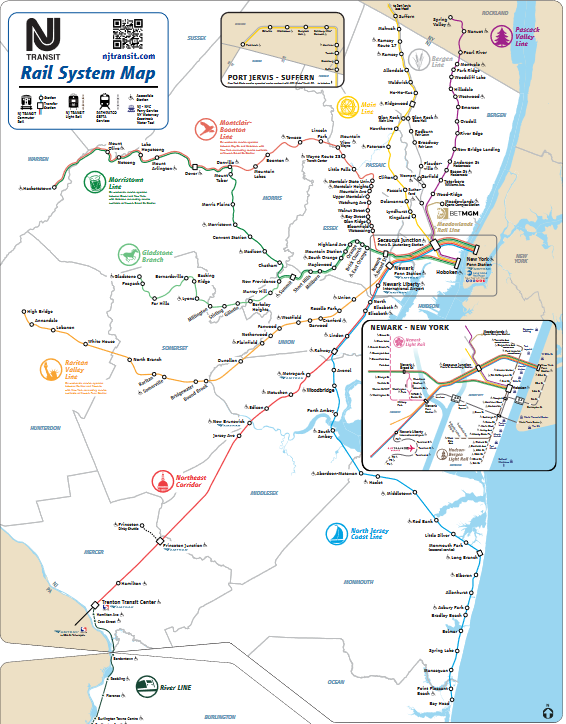

## 2.2 Average Train Delays per Train

Some trains are more likely to be delayed on certain lines, and we attempt to study them here.

In [ ]:
train_delay_df = trains_merged_df[['train_id', 'delay_minutes', 'line']].groupby(by=['train_id', 'line']).mean().reset_index().sort_values(by='delay_minutes')

train_delay_df.head()

,train_id,line,delay_minutes
1202,7633,No Jersey Coast,0.025000
677,4110,Princeton Shuttle,0.036359
806,4279,Princeton Shuttle,0.040132
669,4102,Princeton Shuttle,0.042281
771,4238,Princeton Shuttle,0.045119


In [ ]:
train_delay_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1321 entries, 1202 to 1301
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   train_id       1321 non-null   int64  
 1   line           1321 non-null   object 
 2   delay_minutes  1321 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 41.3+ KB


Text(0.5, 1.0, 'Top 20 delayed trains')

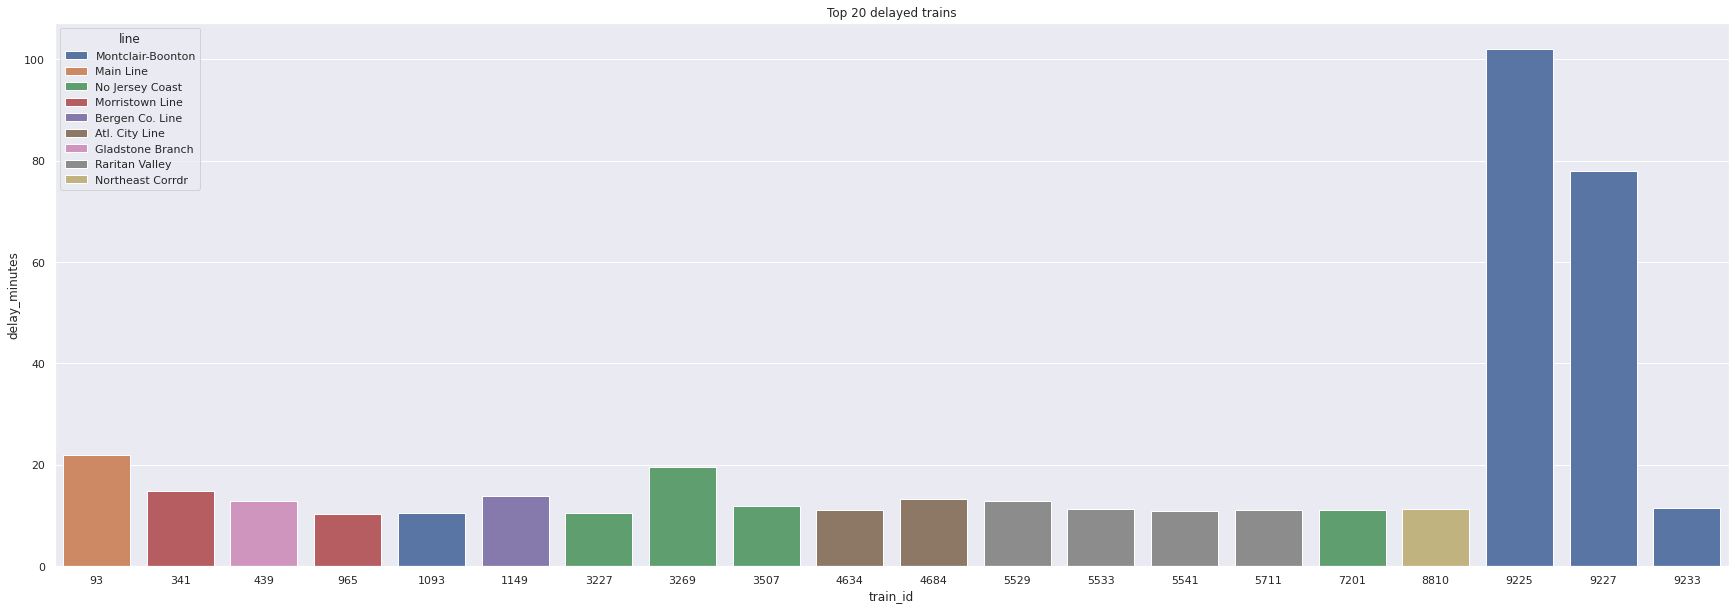

In [ ]:
sb.set(rc={"figure.figsize":(30, 10)}) #width=30, height=10
sb.barplot(data=train_delay_df.sort_values(by='delay_minutes', ascending=False).head(20), x='train_id', y='delay_minutes', hue='line', dodge=False)
plt.title('Top 20 delayed trains')

Train 9225 and 9227 seem to be outliers as thier average delay time is >100 minutes and >80 minutes respectively. Let's analyze their the delay times for these trains.

In [ ]:
train_9225_df = train_delay_df[train_delay_df['train_id']==9225]

In [ ]:
train_9225_df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
159278,2018-03-21,9225,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-21 13:17:00,2018-03-21 13:17:10,0.166667,departed,Montclair-Boonton,NJ Transit
159279,2018-03-21,9225,2.0,New York Penn Station,105.0,Newark Broad Street,106.0,2018-03-21 13:33:00,2018-03-21 13:38:09,5.150000,departed,Montclair-Boonton,NJ Transit
159280,2018-03-21,9225,3.0,Newark Broad Street,106.0,Watsessing Avenue,154.0,2018-03-21 13:40:00,2018-03-21 13:45:04,5.066667,departed,Montclair-Boonton,NJ Transit
159281,2018-03-21,9225,4.0,Watsessing Avenue,154.0,Bloomfield,19.0,2018-03-21 13:42:00,2018-03-21 13:47:10,5.166667,departed,Montclair-Boonton,NJ Transit
159282,2018-03-21,9225,5.0,Bloomfield,19.0,Glen Ridge,50.0,2018-03-21 13:45:00,2018-03-21 13:51:04,6.066667,departed,Montclair-Boonton,NJ Transit


In [ ]:
train_9225_df.describe()

,train_id,stop_sequence,from_id,to_id,delay_minutes
count,36.0,36.00000,36.000000,36.00000,36.000000
mean,9225.0,6.50000,99.333333,3264.00000,102.100000
std,0.0,3.50102,48.649769,10646.74277,69.050491
min,9225.0,1.00000,14.000000,14.00000,0.166667
25%,9225.0,3.75000,79.250000,79.25000,7.162500
50%,9225.0,6.50000,105.000000,105.50000,149.541667
75%,9225.0,9.25000,150.500000,152.25000,150.433333
max,9225.0,12.00000,154.000000,38081.00000,153.133333


## 2.3 Average delay per Line

NJ Transit employs 11 lines, and the average delay on each line through the year is shown below.

In [ ]:
# delays by Lines

lines_delay_df = trains_merged_df[['delay_minutes', 'line']].groupby(by=['line']).mean().reset_index().sort_values(by='delay_minutes', ascending=False)

lines_delay_df.head()

,line,delay_minutes
6,No Jersey Coast,4.709266
0,Atl. City Line,4.665933
10,Raritan Valley,4.564398
4,Montclair-Boonton,4.247120
7,Northeast Corrdr,4.181004


Text(0.5, 1.0, 'Train Delays vs Train Line')

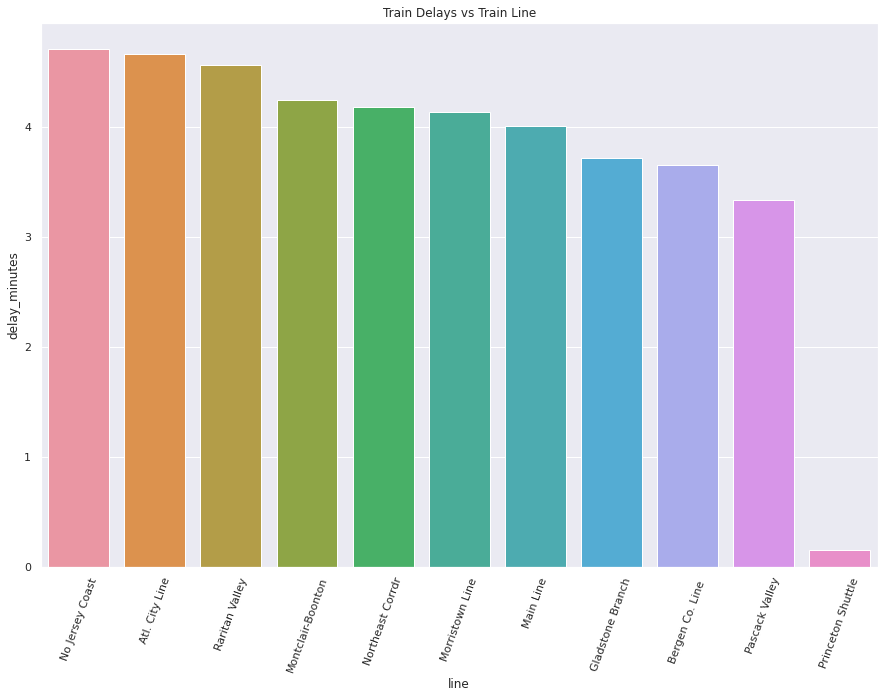

In [ ]:
sb.set(rc={"figure.figsize":(15, 10)}) #width=30, height=10
sb.barplot(data=lines_delay_df, x='line', y='delay_minutes', dodge=False)
plt.xticks(rotation=70)
plt.title('Train Delays vs Train Line')

The Princeton Shuttle is a short route that runs from the Princeton Junction to Princeton University on a dedicated track, and is therefore not as delayed when compared to the other heavy-traffic lines.

## 2.4 Average train delays per Train Station
Here, we analyse the average delays when considering a train that either departs (*FROM*) or arrives (*TO*) at a station.

### 2.4.1 Average train delays per FROM Train Station

In [ ]:
# delays by from stations

stations_from_delay_df = trains_merged_df[['delay_minutes', 'from']].groupby(by=['from']).mean().reset_index().sort_values(by='delay_minutes', ascending=False)

stations_from_delay_df.head()

,from,delay_minutes
136,Secaucus Concourse,8.170000
82,Monmouth Park,7.473215
52,Harriman,6.606777
25,Cherry Hill,6.440567
66,Lindenwold,6.320886


Text(0.5, 1.0, 'Train Delays vs From Station')

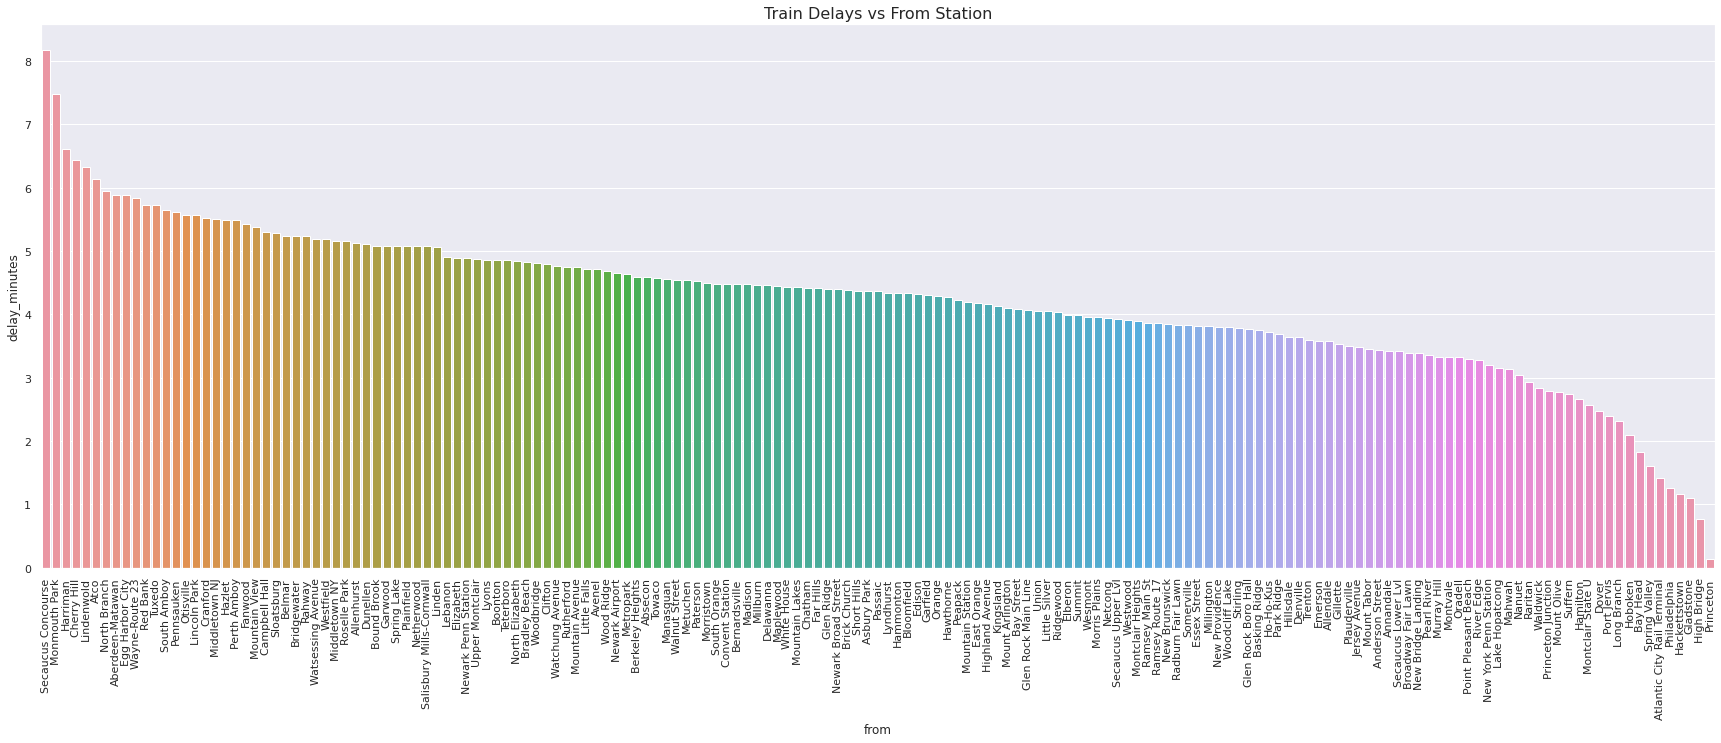

In [ ]:
sns.set(rc={"figure.figsize":(30, 10)}) #width=30, height=10
sns.barplot(data=stations_from_delay_df, x='from', y='delay_minutes', dodge=False)
plt.xticks(rotation=90)
plt.title('Train Delays vs From Station', fontsize=16)

Text(0.5, 1.0, 'Train Delays vs From Station - Top 10')

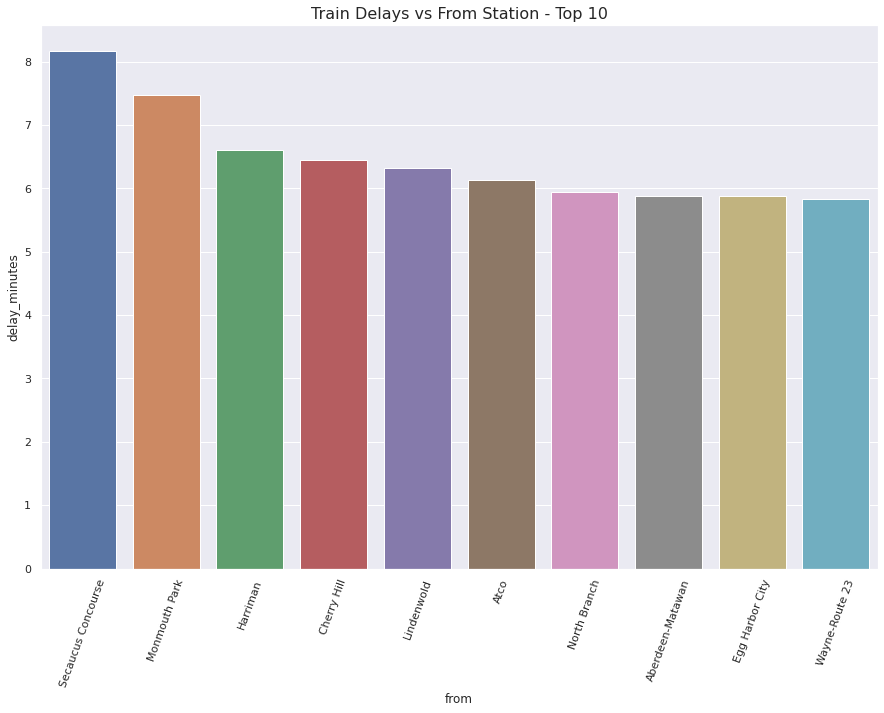

In [ ]:
sns.set(rc={"figure.figsize":(15, 10)}) #width=30, height=10
sns.barplot(data=stations_from_delay_df.head(10), x='from', y='delay_minutes', dodge=False)
plt.xticks(rotation=70)
plt.title('Train Delays vs From Station - Top 10', fontsize=16)

Seacaucus Junction is the most delayed on average, which makes sense, given that it is located in the heart of New York City and serves as a departing port for multiple lines and trains in the North-East.

### 2.4.2 Average train delays per TO Train Station

In [ ]:
# delays by to stations

stations_to_delay_df = trains_merged_df[['delay_minutes', 'to']].groupby(by=['to']).mean().reset_index().sort_values(by='delay_minutes', ascending=False)

stations_to_delay_df.head()

,to,delay_minutes
161,White House,6.006315
150,Tuxedo,5.950762
0,Aberdeen-Matawan,5.905469
54,Hazlet,5.887494
66,Lindenwold,5.868428


Text(0.5, 1.0, 'Train Delays vs To Station')

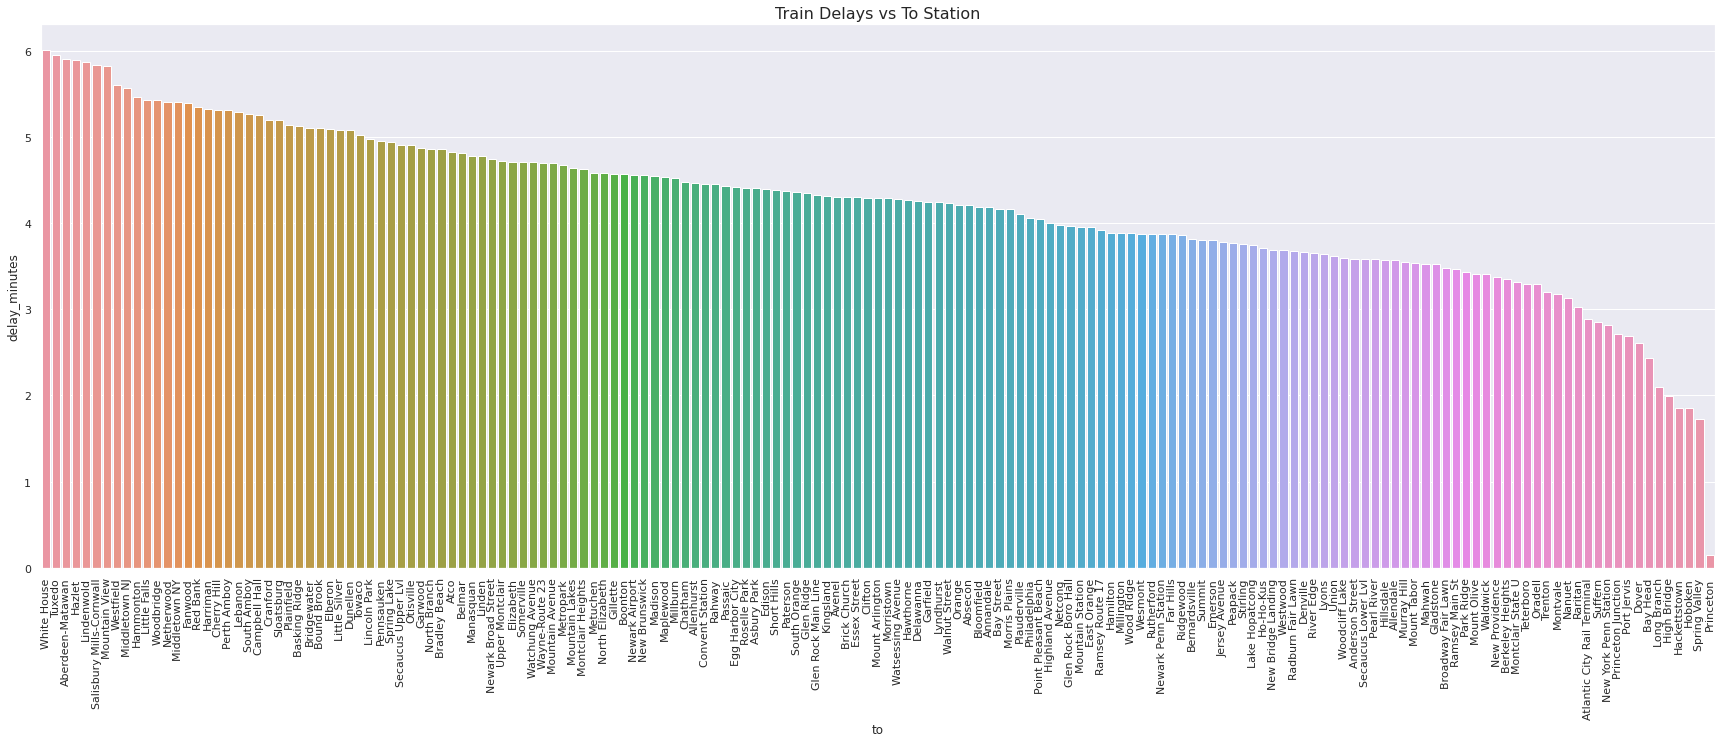

In [ ]:
sns.set(rc={"figure.figsize":(30, 10)}) #width=30, height=10
sns.barplot(data=stations_to_delay_df, x='to', y='delay_minutes', dodge=False)
plt.xticks(rotation=90)
plt.title('Train Delays vs To Station', fontsize=16)

Text(0.5, 1.0, 'Train Delays vs To Station - top 10')

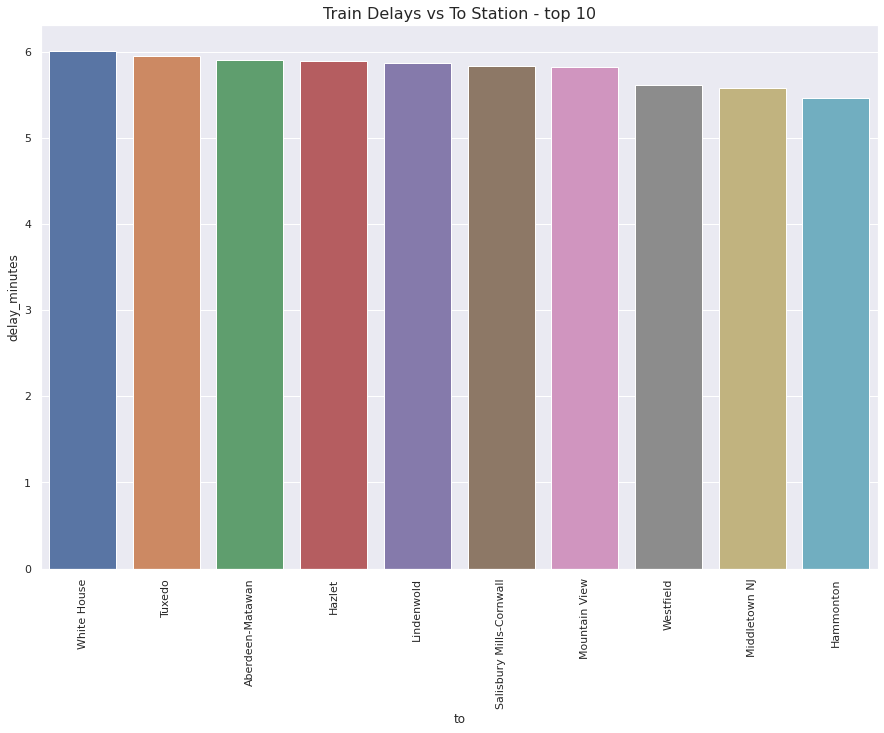

In [ ]:
sns.set(rc={"figure.figsize":(15, 10)}) #width=30, height=10
sns.barplot(data=stations_to_delay_df.head(10), x='to', y='delay_minutes', dodge=False)
plt.xticks(rotation=90)
plt.title('Train Delays vs To Station - top 10', fontsize=16)

### 2.4.3 Average train delays per Train Station (combinbe FROM and TO)

In [ ]:
stations_combined_delay_df = stations_from_delay_df.merge(stations_to_delay_df, how='inner', left_on='from', right_on='to', suffixes=['_from', '_to'])

In [ ]:
stations_combined_delay_df['total_delay_minutes'] = stations_combined_delay_df.apply(lambda x: (x['delay_minutes_from'] + x['delay_minutes_to']) / 2.0, axis=1)

In [ ]:
stations_combined_delay_df.head()

,from,delay_minutes_from,to,delay_minutes_to,total_delay_minutes
0,Harriman,6.606777,Harriman,5.328530,5.967653
1,Cherry Hill,6.440567,Cherry Hill,5.315887,5.878227
2,Lindenwold,6.320886,Lindenwold,5.868428,6.094657
3,Atco,6.134823,Atco,4.821136,5.477979
4,North Branch,5.944550,North Branch,4.856777,5.400664


Text(0, 0.5, 'Avg Train Delay')

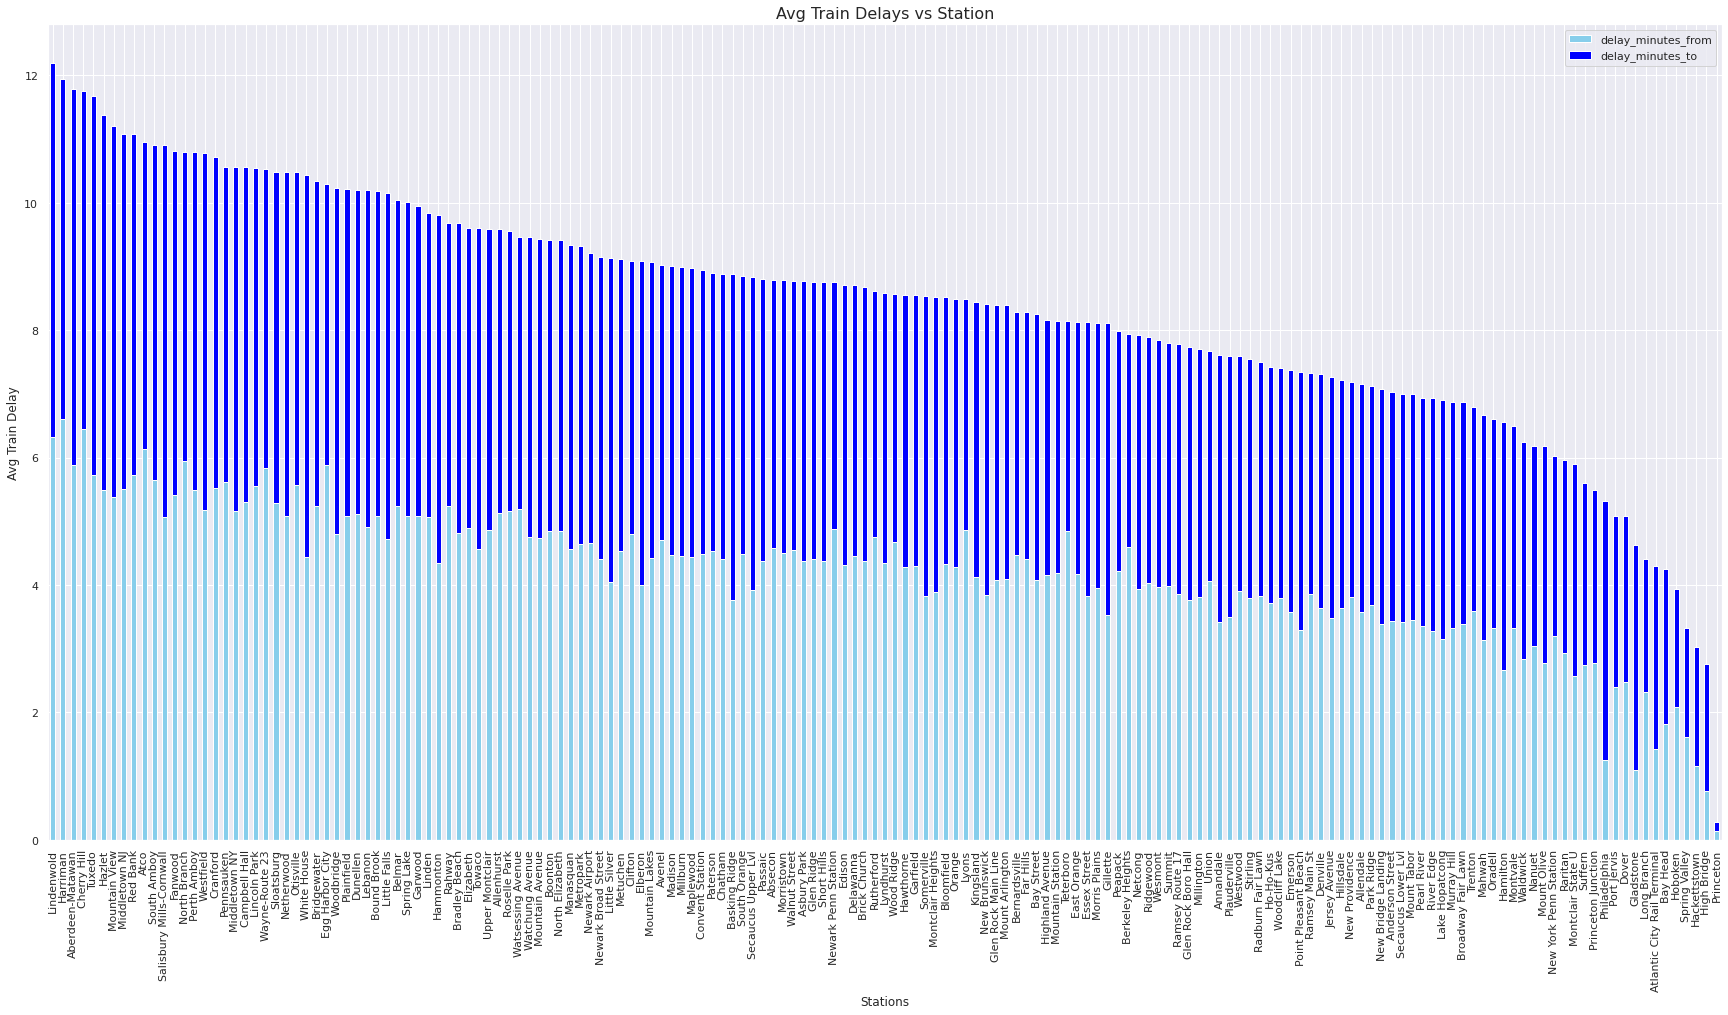

In [ ]:
stations_combined_delay_df.sort_values(by='total_delay_minutes', ascending=False)[['from', 'delay_minutes_from', 'delay_minutes_to' ]].set_index('from').\
plot(kind='bar', stacked=True, color=['skyblue', 'blue'], figsize=(30,15))

plt.title('Avg Train Delays vs Station', fontsize=16)

#add axis titles
plt.xlabel('Stations')
plt.ylabel('Avg Train Delay')

Text(0, 0.5, 'Avg Train Delay')

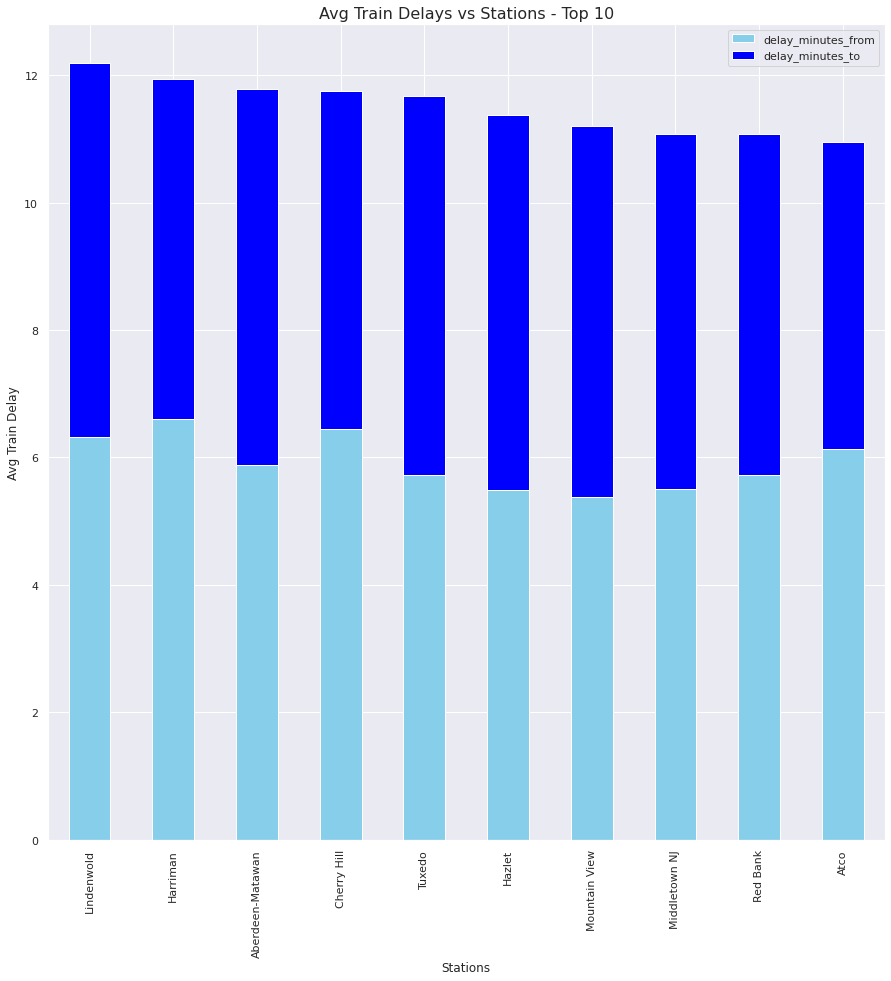

In [ ]:
stations_combined_delay_df.sort_values(by='total_delay_minutes', ascending=False)[['from', 'delay_minutes_from', 'delay_minutes_to' ]].head(10).set_index('from').\
plot(kind='bar', stacked=True, color=['skyblue', 'blue'], figsize=(15,15))


plt.title('Avg Train Delays vs Stations - Top 10', fontsize=16)

#add axis titles
plt.xlabel('Stations')
plt.ylabel('Avg Train Delay')

## 2.5 Display average total delays of station on map

Creating a visualization that shows scaled bubbles according to the average delay at the station.

In [ ]:
station_delay_plotting_df = pd.merge(stations_combined_delay_df, stations_df, how='inner', left_on='from', right_on='station')
station_delay_plotting_df.head()

,from,delay_minutes_x,to,delay_minutes_y,total_delays,total_delay_minutes,station,state,country,address,location,point,latitude,longitude,altitude
0,Harriman,6.606777,Harriman,5.328530,5.967653,5.967653,Harriman,New York,United States of America,"Harriman station, New York, United States of A...","(Harriman, New York State Thruway, Newburgh Ju...","(41.293391, -74.1399076, 0.0)",41.293391,-74.139908,0.0
1,Cherry Hill,6.440567,Cherry Hill,5.315887,5.878227,5.878227,Cherry Hill,New Jersey,United States of America,"Cherry Hill station, New Jersey, United States...","(Cherry Hill, Union Avenue, Garden State Pavil...","(39.9284378, -75.0417589, 0.0)",39.928438,-75.041759,0.0
2,Lindenwold,6.320886,Lindenwold,5.868428,6.094657,6.094657,Lindenwold,New Jersey,United States of America,"Lindenwold station, New Jersey, United States ...","(Lindenwold, Berlin Road, Lindenwold, Camden C...","(39.8338953, -75.0005695, 0.0)",39.833895,-75.000569,0.0
3,Atco,6.134823,Atco,4.821136,5.477979,5.477979,Atco,New Jersey,United States of America,"Atco station, New Jersey, United States of Ame...","(Atco, Hopewell Road, Bishops, Waterford Towns...","(39.7836223, -74.9077919, 0.0)",39.783622,-74.907792,0.0
4,North Branch,5.944550,North Branch,4.856777,5.400664,5.400664,North Branch,New Jersey,United States of America,"North Branch station, New Jersey, United State...","(North Branch, Station Road, North Branch Depo...","(40.5925093, -74.6843032, 0.0)",40.592509,-74.684303,0.0


In [ ]:
# add marker one by one on the map

station_delay_map = fo.Map(location=[40.5681, -74.3298],
                        zoom_start=10,
                        tiles='CartoDB dark_matter')
for i in range(0,len(station_delay_plotting_df)):
   fo.Circle(location=[station_delay_plotting_df.iloc[i]['latitude'], station_delay_plotting_df.iloc[i]['longitude']],
             popup=station_delay_plotting_df.iloc[i]['from'],
             radius=float(station_delay_plotting_df.iloc[i]['total_delay_minutes'])*300,
             color='crimson',
             fill=True,
             fill_color='crimson'
   ).add_to(station_delay_map)

In [ ]:
station_delay_map

##2.6 Delay-Dates Correlations (Seasonality)
We attempt to study whether trains tend to be more delayed on certain days of the week or months of the year, possibly hinting towards some seasonality in the data.

In [ ]:
trains_merged_df['date'] = pd.to_datetime(trains_merged_df['date'])

In [ ]:
trains_merged_df['day'] = trains_merged_df['date'].dt.dayofweek
trains_merged_df['day_name'] = trains_merged_df['date'].dt.day_name()
trains_merged_df['month_name'] = trains_merged_df['date'].dt.month_name()

Text(0.5, 1.0, 'Delay By Day')

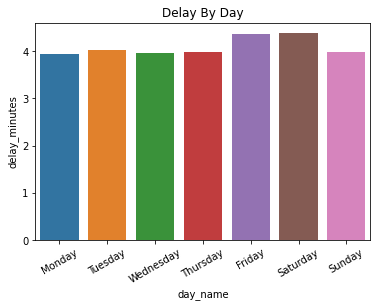

In [ ]:
sns.barplot(data = trains_merged_df[['day_name','delay_minutes']].\
            groupby(by=['day_name']).mean().reset_index(),
            x = 'day_name', y = 'delay_minutes',
            order=['Monday','Tuesday','Wednesday',
                   'Thursday','Friday',
                   'Saturday','Sunday'])
plt.xticks(rotation = 30)
plt.title('Delay By Day')

The trains tend to be more delayed towards the weekend, with Friday and Saturday barely edging out the other other days of the week.

Text(0.5, 1.0, 'Delay By Month')

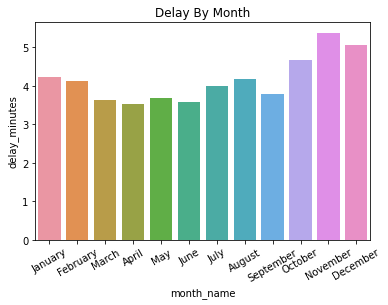

In [ ]:
sns.barplot(data = trains_merged_df[['month_name','delay_minutes']].\
            groupby(by=['month_name']).mean().reset_index(),
            x = 'month_name', y = 'delay_minutes',
            order = ['January','February','March','April',
                     'May','June','July','August',
                     'September','October','November','December'])
plt.xticks(rotation=30)
plt.title('Delay By Month')

As we'll see later, certain weather elements are seen to be more correlated with the delay, especially rain, snow and wind. This would explain the above plot, where the winters, with harsher weather, are seeing more delays.

Text(0.5, 1.0, 'Time Series For Average Delay Per Day')

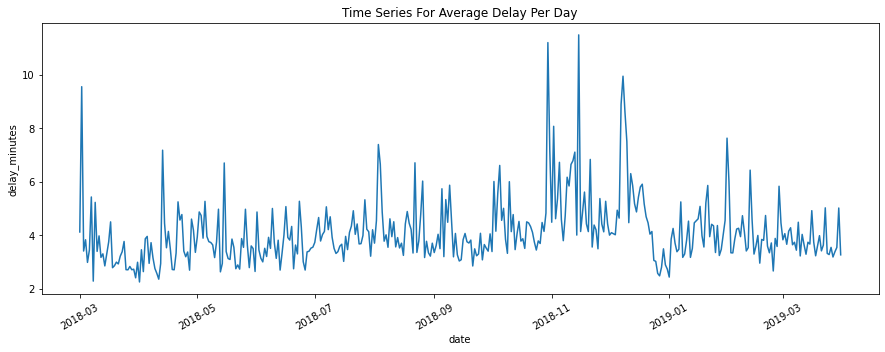

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(data = trains_merged_df[['date','delay_minutes']].groupby(by=['date']).mean().reset_index(),
             x = 'date',
             y = 'delay_minutes')
plt.xticks(rotation = 30)
plt.title('Time Series For Average Delay Per Day')

The above time-series shows roughly the same correlations seen in the month-delay plot, with the average delay peaking around winter times.

##2.7 Weather Data EDA and Merging

We analyse the weather data independently before merging it with our train dataset, in order to do any necessary feature engineering before creating a much larger dataset that could get difficult to work with.

###2.7.1 Weather EDA

In [ ]:
weather_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137441 entries, 0 to 137440
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              137441 non-null  object 
 1   datetime          137441 non-null  object 
 2   tempmax           137441 non-null  float64
 3   tempmin           137441 non-null  float64
 4   temp              137441 non-null  float64
 5   feelslikemax      137441 non-null  float64
 6   feelslikemin      137441 non-null  float64
 7   feelslike         137441 non-null  float64
 8   dew               137441 non-null  float64
 9   humidity          137441 non-null  float64
 10  precip            137441 non-null  float64
 11  precipprob        137441 non-null  int64  
 12  precipcover       137441 non-null  float64
 13  preciptype        66343 non-null   object 
 14  snow              137441 non-null  float64
 15  snowdepth         137441 non-null  float64
 16  windgust          10

Using the first year of the dataset, akin to what has been done for the trains dataset

In [ ]:
#For first year of data
weather_training_merged_df = weather_merged_df[weather_merged_df['datetime']<'2019-04-01'] 

Plotting correlations between all weather features. 

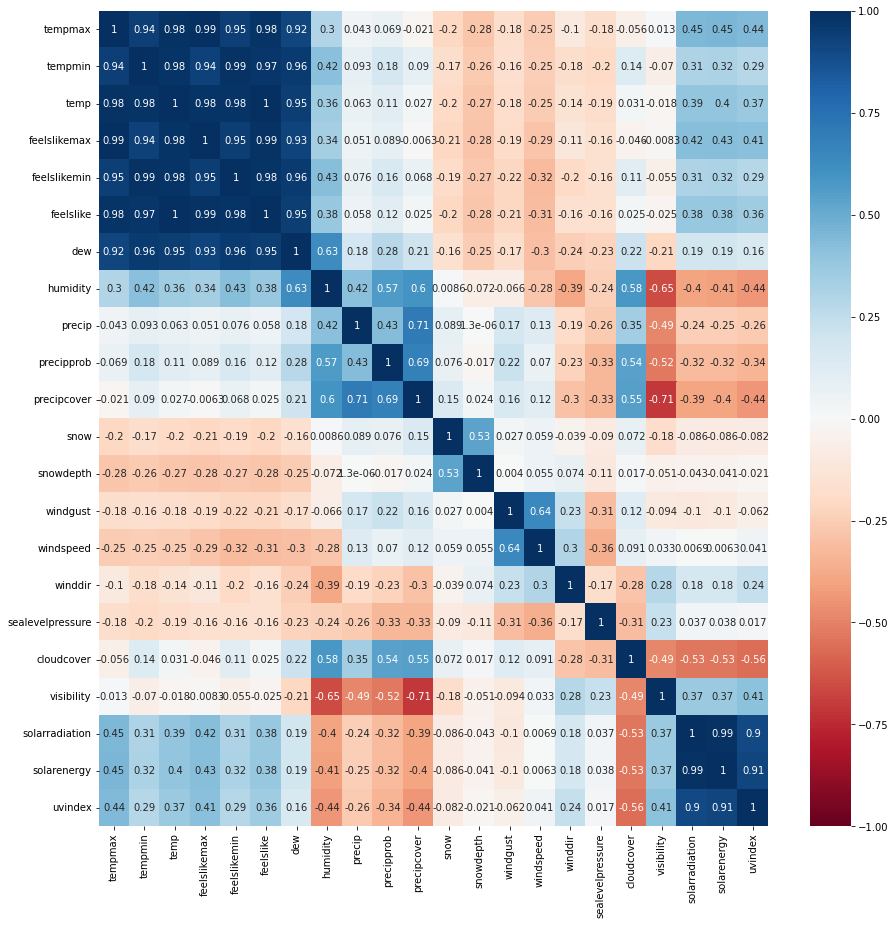

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(weather_training_merged_df.iloc[:,2:].corr(),
            cmap='RdBu',
            vmin=-1,vmax=1,
            annot=True)

As can be seen through the correlation matrix above, certain weather features are highly correlated, and these can be detrimental while modelling the weather-delay relations. Thus we elect to drop highly-correlated features (threshold 0.9)

In [ ]:
weather_training_merged_df = weather_training_merged_df.drop(labels = ['dew','tempmax','tempmin','feelslike',
                                                     'feelslikemax','feelslikemin',
                                                     'precipprob','preciptype',
                                                     'solarradiation','precipprob',
                                                     'solarenergy','uvindex'],
                                           axis = 1,errors='ignore')

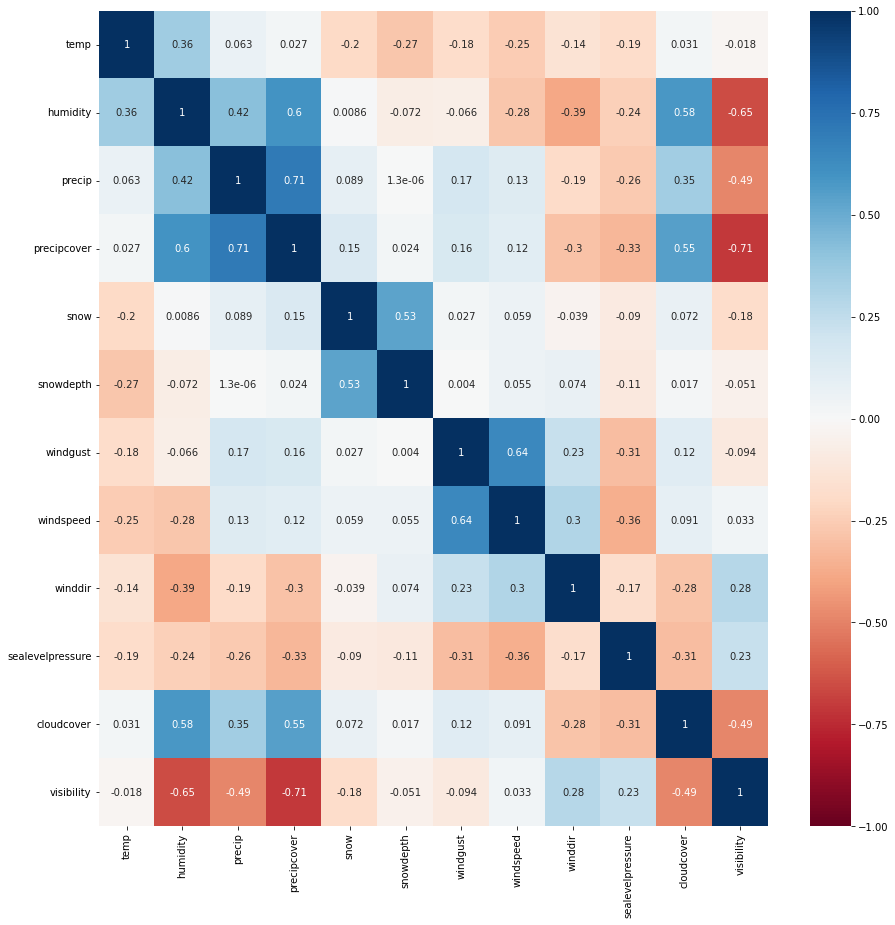

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(weather_training_merged_df.iloc[:,2:].corr(),
            cmap='RdBu',
            vmin=-1,vmax=1,
            annot=True)

There are still certain features that have a decently high correlation (eg. Precipcover with Visibility, Precip), but we will deal with them as necessary in the modelling section.

###2.7.2 Merging Train Delay and Weather Data
Obtaining our primary dataframe for modelling by combining the weather and train dataset for the training range (March 2018 to March 2019).

In [ ]:
trains_weather_merged_df = (trains_merged_df.merge(\
                                                  weather_training_merged_df,
                                                  left_on=['date','from'],
                                                  right_on=['datetime','name']
                                                  )).\
                                                  merge(
                                                      weather_training_merged_df,
                                                      left_on=['date','to'],
                                                      right_on=['datetime','name'],
                                                      suffixes=['_from','_to']
                                                      )

###2.7.3 From and To Correlations
One possible requirement in our modelling could be to recognise that the weather at the departing and arrival station, both play a part in the delay of the train, if at all. However, while adding these features to our dataset we need to ensure that we don't compromise its non-collinearity.

Text(0.5, 1.0, 'Correlations Between Weather Elements at From and To Stations')

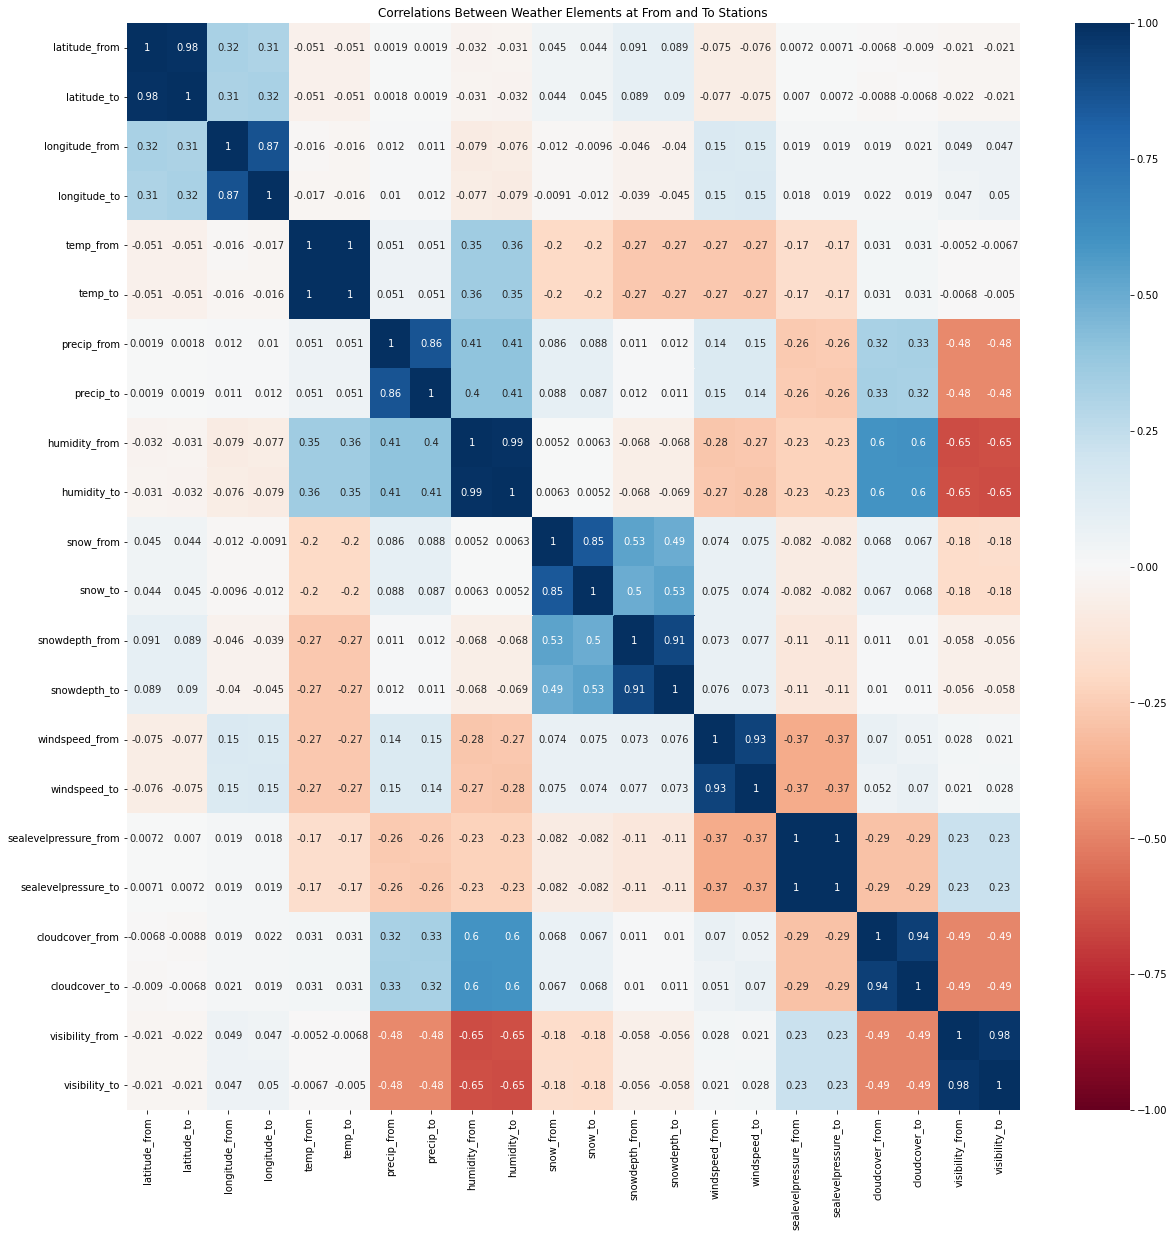

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(trains_weather_merged_df[['latitude_from', 'latitude_to',
                                      'longitude_from', 'longitude_to',
                                      'temp_from','temp_to',
                                      'precip_from','precip_to',
                                      'humidity_from','humidity_to',
                                      'snow_from','snow_to',
                                      'snowdepth_from','snowdepth_to',
                                      'windspeed_from','windspeed_to',
                                      'winddir_from','winddir_to',
                                      'sealevelpressure_from','sealevelpressure_to',
                                      'cloudcover_from','cloudcover_to',
                                      'visibility_from','visibility_to']].corr(),
            cmap='RdBu',
            vmin=-1,vmax=1,
            annot=True)
plt.title('Correlations Between Weather Elements at From and To Stations')

As seen above, most of the weather elements are highly correlated. One solution to removing this collinearity is to create an average of the columns which can then carry the effect of weather at all stations. Done below.

In [ ]:
feat_cols = ['temp','precip','humidity','snow',
             'snowdepth','windspeed','winddir'
             'sealevelpressure','cloudcover','visibility']
for f in feat_cols:
  trains_weather_merged_df[f+ '_avg'] = (trains_weather_merged_df[f+'_from']+trains_weather_merged_df[f+'_to'])/2

Text(0.5, 1.0, 'Correlations Between Weather Elements at From and To Stations')

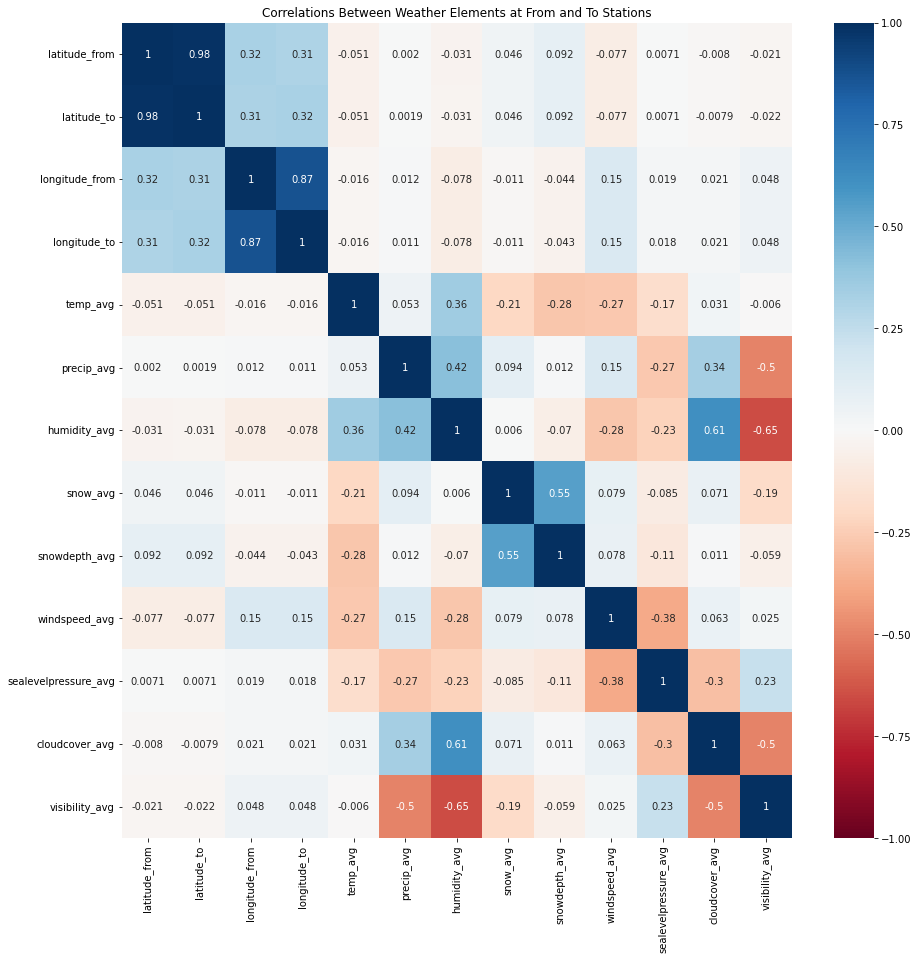

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(trains_weather_merged_df[['latitude_from', 'latitude_to',
                                      'longitude_from', 'longitude_to',
                                      'temp_avg',
                                      'precip_avg',
                                      'humidity_avg',
                                      'snow_avg',
                                      'snowdepth_avg',
                                      'windspeed_avg',
                                      'winddir_avg',
                                      'sealevelpressure_avg',
                                      'cloudcover_avg',
                                      'visibility_avg']].corr(),
            cmap='RdBu',
            vmin=-1,vmax=1,
            annot=True)
plt.title('Correlations Between Weather Elements at From and To Stations')

In [ ]:
# trains_weather_merged_df.to_csv('./merged_trains_weather_data_03_2018_to_03_2019.csv', encoding='utf-8', index=False)

In [ ]:
trains_weather_merged_df.columns

Index(['date', 'train_id', 'stop_sequence', 'from', 'from_id', 'to', 'to_id',
       'scheduled_time', 'actual_time', 'delay_minutes', 'status', 'line',
       'type', 'delay_minutes_updated', 'latitude_from', 'longitude_from',
       'latitude_to', 'longitude_to', 'name_from', 'datetime_from',
       'temp_from', 'humidity_from', 'precip_from', 'precipcover_from',
       'snow_from', 'snowdepth_from', 'windgust_from', 'windspeed_from',
       'winddir_from', 'sealevelpressure_from', 'cloudcover_from',
       'visibility_from', 'name_to', 'datetime_to', 'temp_to', 'humidity_to',
       'precip_to', 'precipcover_to', 'snow_to', 'snowdepth_to', 'windgust_to',
       'windspeed_to', 'winddir_to', 'sealevelpressure_to', 'cloudcover_to',
       'visibility_to'],
      dtype='object')

To note from the above heatmap: the latitude and longitude for the stations are also extremely coorelated - understandably, since most stations are close to each other and follow the geometry of the NJ transit lines, which are largely linear routes. This collinearity is addressed in the modelling section through the same solution (averaging).

##2.8 Weather-Delay Visualizations

Now, before our modelling begins, we will attempt to draw some rough correlations between the weather elements and the train delays. These are by no means indicative of the feature importance for our dataset, but may be helpful in understanding the behavior of our models later on.

We start below by binning the data for all the weather elements into 15 intervals, and plotting the average delay across these intervals

In [ ]:
bins = 15
feat_cols = ['temp','precip','humidity','snow',
             'snowdepth','windspeed', 'sealevelpressure',
             'cloudcover','visibility']
for f in feat_cols:
  trains_weather_merged_df[f+'_bin'] = pd.cut(trains_weather_merged_df[f+'_avg'],bins)  

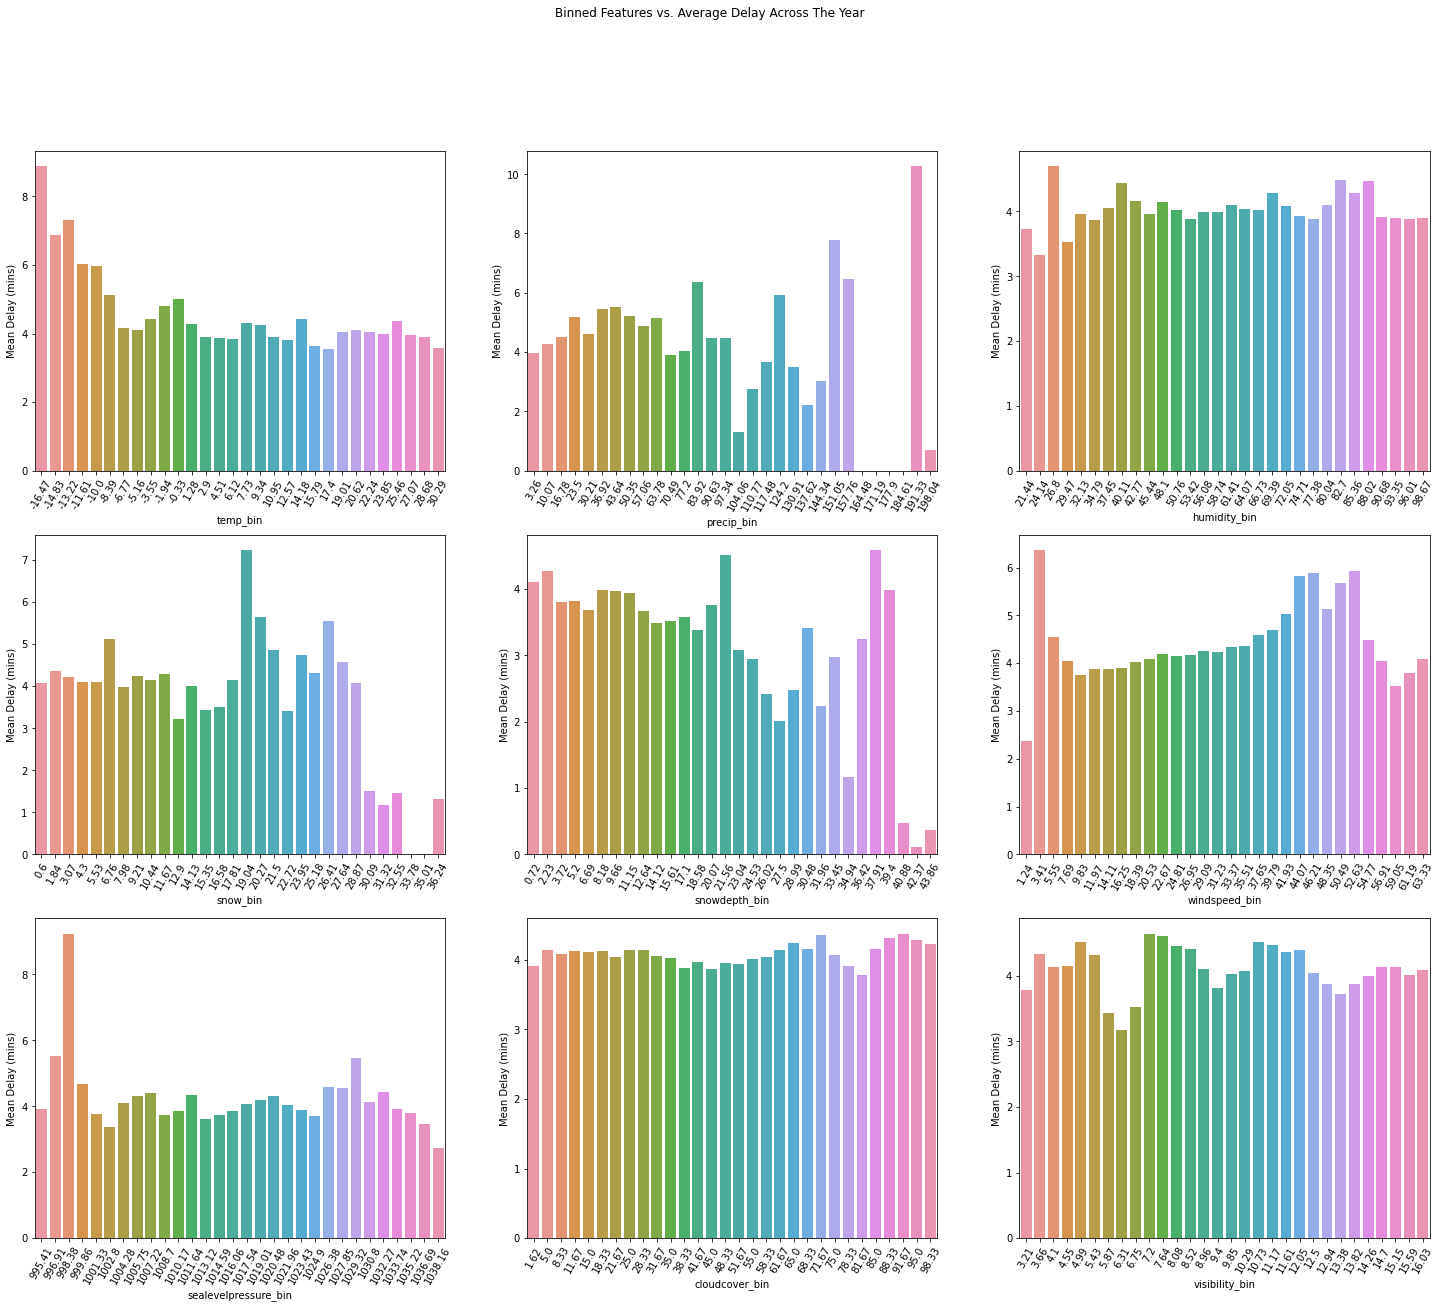

In [ ]:
fig, axes = plt.subplots(3,3)
fig.set_figheight(20)
fig.set_figwidth(25)
fig.suptitle('Binned Features vs. Average Delay Across The Year')
for i in range(len(feat_cols)):
  ax = axes.flatten()[i]
  feat_mean_delay = trains_weather_merged_df[[feat_cols[i]+'_bin','delay_minutes']].groupby(feat_cols[i]+'_bin').mean().reset_index()
  sns.barplot(data = feat_mean_delay,x=feat_cols[i]+'_bin',y='delay_minutes',ax=ax)
  ax.set_xticklabels(feat_mean_delay[feat_cols[i]+'_bin'].apply(lambda x: round(x.mid,2)),
                     rotation = 60)
  ax.set_ylabel('Mean Delay (mins)')
plt.show()

As seen above, some features show a rough correlation with train delays, such as the temperature, which sees a spike at its lowest bin, possibly indicating that near freezing temperatures cause significant delays (and probably correlated with snowfall).

###Rating Charts
Creating more discretized versions of the above plots, we divide the weather elements into categories of mild (low), medium and extreme (high) weather.

In [ ]:
for f in feat_cols:
  trains_weather_merged_df[f+ '_rating'] = pd.cut(trains_weather_merged_df[f+'_avg'], 3, labels=False)

In [ ]:
ratings_df = pd.DataFrame()
for f in feat_cols:
  temp_df = trains_weather_merged_df[[f+'_rating','delay_minutes']].groupby(by=[f+'_rating']).mean().reset_index()
  temp_df.rename(columns = {f+'_rating':'rating'}, inplace = True)
  temp_df['element'] = f
  ratings_df = pd.concat([ratings_df,
                         temp_df],
                         axis = 0)
ratings_df['rating'].replace({0:'Low',1:'Medium',2:'High'},inplace = True)

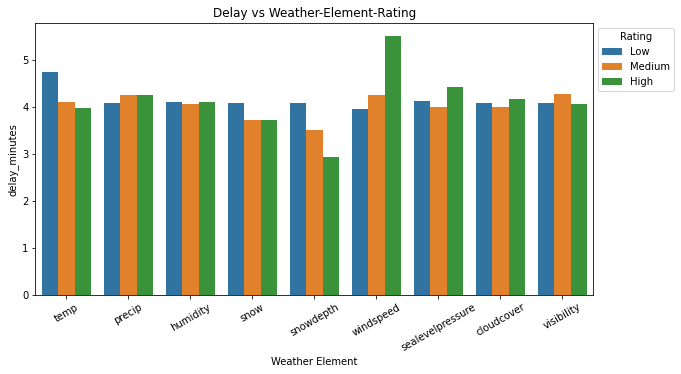

In [ ]:
plt.figure(figsize = (10,5))
sns.barplot(data = ratings_df,
            x = 'element',
            y = 'delay_minutes',
            hue = 'rating')
plt.xticks(rotation = 30)
plt.xlabel('Weather Element')
plt.title('Delay vs Weather-Element-Rating')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left',title = "Rating")

The above portrays a little more clearly that the higher windspeeds may be causing higher delays on average.

# 3. Modelling

The main hypothesis we are interested in testing is if the weather alone causes delyas in trains. 

For this specific reason we ignore most of purely rail specific data like, train number, rail line etc. and focus predominatly on the weather features.

Most other approaches to this problem frame it as a binary classification task of predicting whether there would be a delay or not. But, here we are posing it as regression problem tasked with predicting the exact delay which is much more useful but difficult task.

<br>
---

<br>

*A Note on Seasonality:*

In this modelling, we do not consider the seasonality of data for a couple of reasons:


1.   Data Size: Our current dataset spanned over three years, out of which we were able to only work with a range of one year. This can not give us enough data to model seasonality.
2.   The Problem Objective: More importantly, the entire premise of the problem is to model the relationship between the season/weather and the delays. Hence, modifying or standardizing the weather will remove the effect it has on the delay.



After extensive and EDA and removing correlated features. We now move on to predict the train delay using ML models.

## 3.1 Train-Validation-Test Split

We split the data over the period of an year (2018-03 to 2019-03) into Train-Val-Test split.

**Train data: 60% of the data (1.6M records)**

**Validation Data: 20% of the data (500K records)**

**Testing Data: 20% of the data (500K records)**



---




We use the following features and labels:

**Features:**

latitude_from        
longitude_from       
latitude_to          
longitude_to         
temp_from            
humidity_from        
precip_from          
snow_from            
snowdepth_from       
windspeed_from       
winddir_from         
sealevelpressure_from   
cloudcover_from      
visibility_from      
temp_to              
humidity_to          
precip_to            
snow_to              
snowdepth_to         
windspeed_to         
winddir_to           
sealevelpressure_to  
cloudcover_to        
visibility_to        


**Label:**

Delay minutes updated:

This is the stop to stop delay accounting for the train delay at all the prior stops. This removes the dependency of the delay from the prior stops(eg: cumulative delay) and allows each datapoint to be prrocessed independtly of the prior stops made by the train.

In [ ]:
train_weather_df = pd.read_csv("/content/drive/Shareddrives/CIS545 Project/Data/merged_trains_avg_weather_data_03_2018_to_03_2019.csv")

In [ ]:
train_weather_updated_df = train_weather_df[train_weather_df['stop_sequence'] != 1]

In [ ]:
X = train_weather_updated_df[['stop_sequence','latitude_from', 'longitude_from',
       'latitude_to', 'longitude_to','temp_from', 'humidity_from',
       'precip_from','snow_from', 'snowdepth_from', 'windspeed_from',
       'winddir_from', 'sealevelpressure_from', 'cloudcover_from',
       'visibility_from', 'temp_to', 'humidity_to',
       'precip_to', 'snow_to', 'snowdepth_to',
       'windspeed_to', 'winddir_to', 'sealevelpressure_to', 'cloudcover_to',
       'visibility_to', 'temp_avg', 'precip_avg', 'humidity_avg', 'snow_avg',
       'snowdepth_avg', 'windspeed_avg', 'sealevelpressure_avg',
       'cloudcover_avg', 'visibility_avg', 'latitude_avg',
       'longitude_avg']]
y = train_weather_updated_df[['delay_minutes','delay_minutes_updated']]

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X.drop(['stop_sequence', 'temp_avg', 'precip_avg', 'humidity_avg', 'snow_avg',
       'snowdepth_avg', 'windspeed_avg', 'sealevelpressure_avg',
       'cloudcover_avg', 'visibility_avg', 'latitude_avg',
       'longitude_avg', ],axis=1), y[['delay_minutes_updated']],
                      test_size = 0.2, random_state = 42)
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_1, y_train_1,
                                                          random_state=42, 
                                                          test_size=0.25)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(trains_weather_updated_df.drop(["delay_minutes_updated"], axis=1),
                                                    trains_weather_updated_df["delay_minutes_updated"],
                                                    random_state=42,
                                                    shuffle=True, 
                                                    test_size=0.2)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  random_state=42,
                                                  shuffle=True, 
                                                  test_size=0.25)

## 3.2 Linear Regression

We will try Ordinary Least Squares regression.

We chose OLS as it does not require standardization of features and has a closed form solution. Our dataset is large and iterating with gradient descent over the entire dataset might be too slow and hence a model with a closed form solution is preferred.

In [ ]:
model = LinearRegression()
model.fit(X_train_1, y_train_1)

LinearRegression()

In [ ]:
model.intercept_

array([-4.69626956])

In [ ]:
model.coef_

array([[-2.58685427e+00,  9.95725886e-01,  2.81547880e+00,
        -8.77927339e-01,  2.12749548e-01,  5.61874202e-02,
         5.64511272e-03,  4.66069740e-03,  1.21037636e-02,
         1.24152241e-04, -2.46901377e-04,  4.17529770e-01,
        -2.76196819e-03,  1.85675007e-01, -2.09722571e-01,
        -5.64824108e-02, -2.81532928e-03,  3.34677023e-03,
        -1.07851645e-02,  5.99110198e-03,  2.08830749e-04,
        -4.13607798e-01,  3.78551729e-03, -1.80318046e-01]])

In [ ]:
y_train_preds = model.predict(X_train_1)
y_val_preds = model.predict(X_val_1)
y_test_preds = model.predict(X_test_1)

In [ ]:
print('Linear regresssion')
print('----------------------------------------------------------')
print('Train Metrics: ')
print(f'r2 score:  {r2_score(y_train_1, y_train_preds)}')
print(f'mse score: {mean_squared_error(y_train_1, y_train_preds)}')
print(f'mae score: {mean_absolute_error(y_train_1, y_train_preds)}')
print('----------------------------------------------------------')
print('Val Metrics: ')
print(f'r2 score:  {r2_score(y_val_1, y_val_preds)}')
print(f'mse score: {mean_squared_error(y_val_1, y_val_preds)}')
print(f'mae score: {mean_absolute_error(y_val_1, y_val_preds)}')
print('----------------------------------------------------------')
print('Test Metrics: ')
print(f'r2 score:  {r2_score(y_test_1, y_test_preds)}')
print(f'mse score: {mean_squared_error(y_test_1, y_test_preds)}')
print(f'mae score: {mean_absolute_error(y_test_1, y_test_preds)}')
print('----------------------------------------------------------')

Linear regresssion
----------------------------------------------------------
Train Metrics: 
r2 score:  0.010216121866832184
mse score: 7.019839460908184
mae score: 1.2847377771894521
----------------------------------------------------------
Val Metrics: 
r2 score:  0.01027559954123447
mse score: 7.002743426144695
mae score: 1.2837352810240041
----------------------------------------------------------
Test Metrics: 
r2 score:  0.01040348603099539
mse score: 6.892541719005949
mae score: 1.285585714871366
----------------------------------------------------------


We observe that the metrics for OLS are poor for training, validation and test.

### Distributions

To understand what was going wrong we did a further analysis on the  distribution of labels essentially modelling P(Y|X) which our model is trying to learn.

We observed that the true distribution of delays is quite peculiar. This is dicussed further in the Fture Scope section.<br><br>


Observe that the Linear model is not able to capture the exact distribution and instead fit a function which approximates a normal distribution, which results in the high error rate observed.


[]

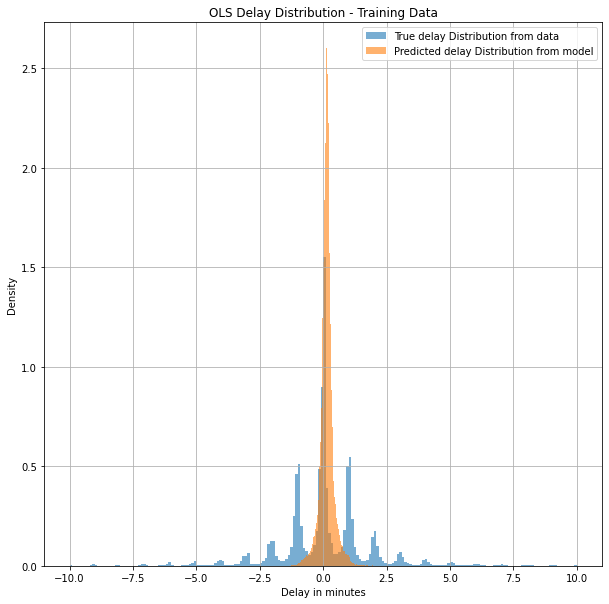

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(y_train_1[abs(y_train_1['delay_minutes_updated'])<10]['delay_minutes_updated'],bins = 200,alpha = 0.6,density=True, label='True delay Distribution from data')
plt.hist(y_train_preds[abs(y_train_preds) < 10], bins = 200,alpha = 0.6, density=True, label='Predicted delay Distribution from model')
plt.xlabel('Delay in minutes')
plt.ylabel('Density')
plt.title('OLS Delay Distribution - Training Data')
plt.legend()
plt.grid()
plt.plot()

[]

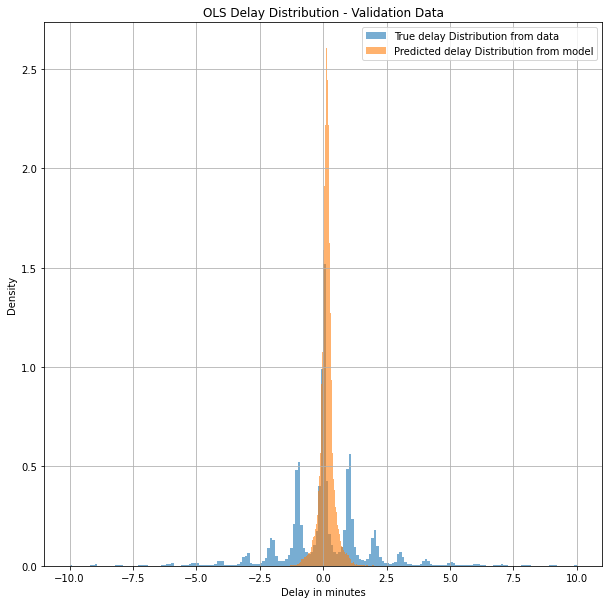

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(y_val_1[abs(y_val_1['delay_minutes_updated'])<10]['delay_minutes_updated'],bins = 200,alpha = 0.6,density=True, label='True delay Distribution from data')
plt.hist(y_val_preds[abs(y_val_preds) < 10], bins = 200,alpha = 0.6, density=True, label='Predicted delay Distribution from model')
plt.xlabel('Delay in minutes')
plt.ylabel('Density')
plt.title('OLS Delay Distribution - Validation Data')
plt.legend()
plt.grid()
plt.plot()

## 3.3 PCA + Linear Regression

Next, We tried PCA to further remove multicolinearity and reduce noise in data by dimensionality reduction, after which we fit a OLS model.

In [ ]:
scaler = StandardScaler().fit(X_train_1)
X_train_scaled = scaler.transform(X_train_1)
X_val_scaled = scaler.transform(X_val_1)
X_test_scaled = scaler.transform(X_test_1)

In [ ]:
pca = PCA(n_components=20)
pca.fit(X_train_scaled)

PCA(n_components=20)

In [ ]:
exp_var = pca.explained_variance_ratio_

Text(0.5, 1.0, 'PCA - Explained Variance (20 Components)')

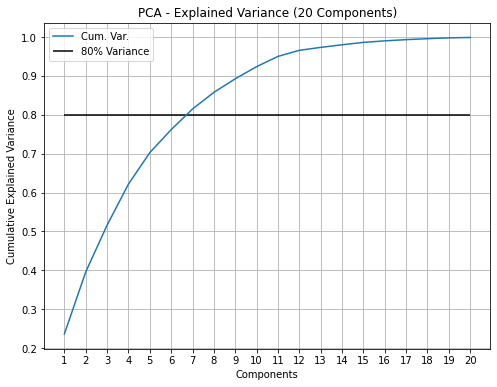

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(exp_var),label='Cum. Var.')
plt.xticks(np.arange(20),np.arange(1,21))
plt.hlines(0.8,0,19,label='80% Variance')
plt.legend()
plt.grid()
plt.xlabel('Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance (20 Components)')

We will choose 9 components as they explain 90% of the variance in the data. 

In [ ]:
pca = PCA(n_components = 9)
pca.fit(X_train_scaled)

PCA(n_components=9)

In [ ]:
X_train_pca = pca.transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
pca.n_components_

9

In [ ]:
model = LinearRegression()
model.fit(X_train_pca, y_train_1)

LinearRegression()

In [ ]:
model.intercept_

array([0.13843876])

In [ ]:
model.coef_

array([[ 0.00796244,  0.01422829, -0.00035869, -0.04276103, -0.0012504 ,
         0.00828514,  0.00984349, -0.01562159, -0.0012153 ]])

In [ ]:
y_train_preds = model.predict(X_train_pca)
y_val_preds = model.predict(X_val_pca)
y_test_preds = model.predict(X_test_pca)

In [ ]:
print('PCA + Linear regresssion')
print('----------------------------------------------------------')
print('Train Metrics: ')
print(f'r2 score:  {r2_score(y_train_1, y_train_preds)}')
print(f'mse score: {mean_squared_error(y_train_1, y_train_preds)}')
print(f'mae score: {mean_absolute_error(y_train_1, y_train_preds)}')
print('----------------------------------------------------------')
print('Val Metrics: ')
print(f'r2 score:  {r2_score(y_val_1, y_val_preds)}')
print(f'mse score: {mean_squared_error(y_val_1, y_val_preds)}')
print(f'mae score: {mean_absolute_error(y_val_1, y_val_preds)}')
print('----------------------------------------------------------')
print('Test Metrics: ')
print(f'r2 score:  {r2_score(y_test_1, y_test_preds)}')
print(f'mse score: {mean_squared_error(y_test_1, y_test_preds)}')
print(f'mae score: {mean_absolute_error(y_test_1, y_test_preds)}')
print('----------------------------------------------------------')

PCA + Linear regresssion
----------------------------------------------------------
Train Metrics: 
r2 score:  0.0008803197451200395
mse score: 7.086051725606648
mae score: 1.2815748705794128
----------------------------------------------------------
Val Metrics: 
r2 score:  0.0008241027290998293
mse score: 7.069616999371467
mae score: 1.2812981115782287
----------------------------------------------------------
Test Metrics: 
r2 score:  0.0007451770538540181
mse score: 6.959811860543737
mae score: 1.2826432059653194
----------------------------------------------------------


The model performance is not better than the original OLS model without the reduced feature set.

### Distributions

From the below distributions we can see that with PCA, the model captures the no-delay predictions correctly but cannot do well when there are delays. This can be attributed to the fact that during PCA the most variance explained/principal components might be oriented in the directions having 0 delay which the model captures well in the reduced dimension space but is unable to capture the data associated with actual delays properly in the lower dimensional space.

[]

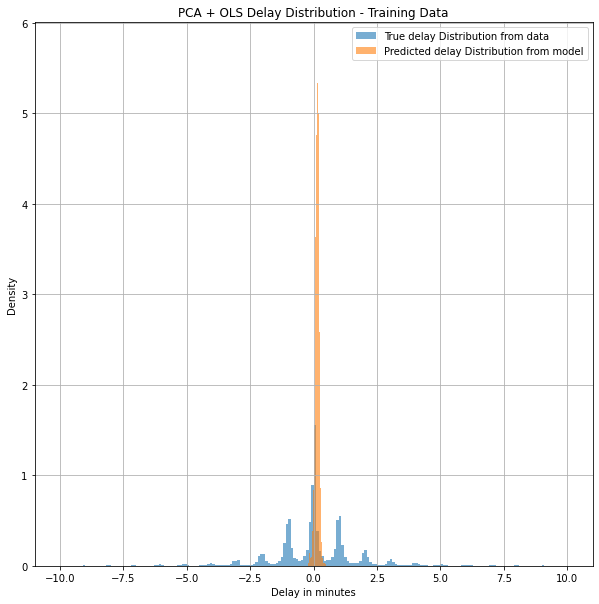

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(y_train_1[abs(y_train_1['delay_minutes_updated'])<10]['delay_minutes_updated'],bins = 200,alpha = 0.6,density=True, label='True delay Distribution from data')
plt.hist(y_train_preds[abs(y_train_preds) < 10], bins = 200,alpha = 0.6, density=True, label='Predicted delay Distribution from model')
plt.xlabel('Delay in minutes')
plt.ylabel('Density')
plt.title('PCA + OLS Delay Distribution - Training Data')
plt.legend()
plt.grid()
plt.plot()

[]

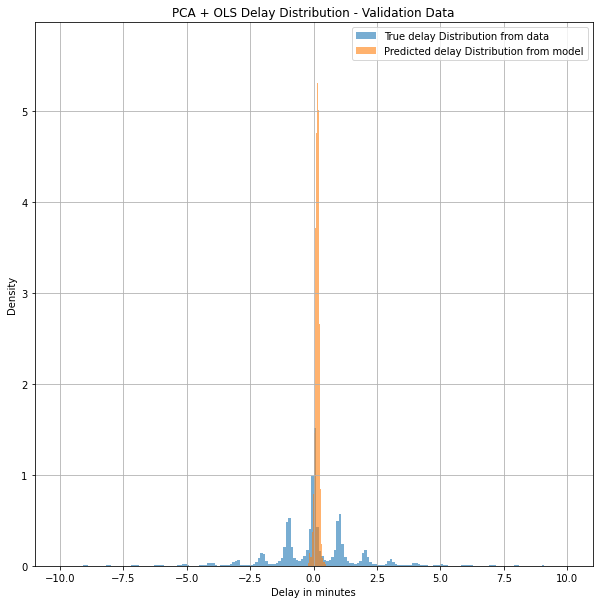

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(y_val_1[abs(y_val_1['delay_minutes_updated'])<10]['delay_minutes_updated'],bins = 200,alpha = 0.6,density=True, label='True delay Distribution from data')
plt.hist(y_val_preds[abs(y_val_preds) < 10], bins = 200,alpha = 0.6, density=True, label='Predicted delay Distribution from model')
plt.xlabel('Delay in minutes')
plt.ylabel('Density')
plt.title('PCA + OLS Delay Distribution - Validation Data')
plt.legend()
plt.grid()
plt.plot()

## 3.4 Decision Trees

We did not venture into regularized linear regression models as it was evident that the prediction model cannot be modelled as a linear function.

Thus we venture into decision trees which are capable of approximating non linear functions.

In [ ]:
# try fitting decision tree regressor on the data

dt_model = DecisionTreeRegressor(max_depth=500)
dt_model.fit(X_train_1, y_train_1.to_numpy().flatten())

DecisionTreeRegressor(max_depth=500)

In [ ]:
dt_model.tree_.max_depth

68

In [ ]:
y_train_preds = dt_model.predict(X_train_1)
y_val_preds = dt_model.predict(X_val_1)
y_test_preds = dt_model.predict(X_test_1)

In [ ]:
print('Decision Tree Regressor')
print('----------------------------------------------------------')
print('Train Metrics: ')
print(f'r2 score:  {r2_score(y_train_1, y_train_preds)}')
print(f'mse score: {mean_squared_error(y_train_1, y_train_preds)}')
print(f'mae score: {mean_absolute_error(y_train_1, y_train_preds)}')
print('----------------------------------------------------------')
print('Val Metrics: ')
print(f'r2 score:  {r2_score(y_val_1, y_val_preds)}')
print(f'mse score: {mean_squared_error(y_val_1, y_val_preds)}')
print(f'mae score: {mean_absolute_error(y_val_1, y_val_preds)}')
print('----------------------------------------------------------')
print('Test Metrics: ')
print(f'r2 score:  {r2_score(y_test_1, y_test_preds)}')
print(f'mse score: {mean_squared_error(y_test_1, y_test_preds)}')
print(f'mae score: {mean_absolute_error(y_test_1, y_test_preds)}')
print('----------------------------------------------------------')

Decision Tree Regressor
----------------------------------------------------------
Train Metrics: 
r2 score:  0.29821635279803715
mse score: 4.977256801697063
mae score: 1.0411995510664513
----------------------------------------------------------
Val Metrics: 
r2 score:  0.11126902784727988
mse score: 6.288169686398405
mae score: 1.1695203210555358
----------------------------------------------------------
Test Metrics: 
r2 score:  0.11090644117244997
mse score: 6.192538433406707
mae score: 1.1688486148750725
----------------------------------------------------------


The model performs marginally better than the OLS models but the performace is still not commendable.

### Distributions

The distribution of predictions for training and validation data are flatter than those of the OLS models.

[]

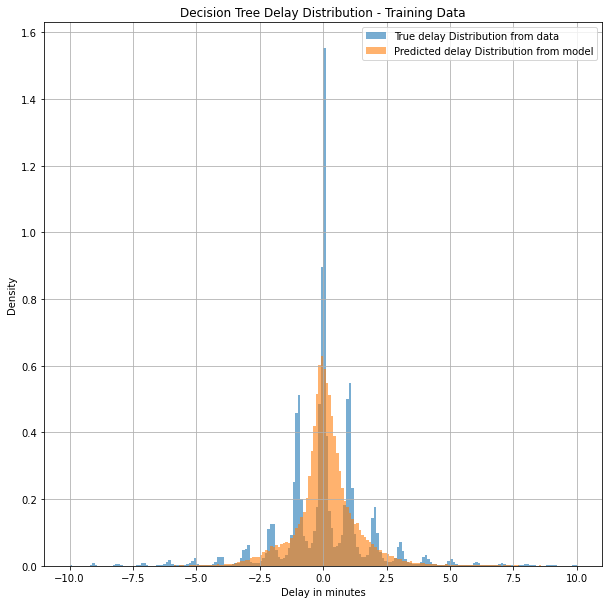

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(y_train_1[abs(y_train_1['delay_minutes_updated'])<10]['delay_minutes_updated'],bins = 200,alpha = 0.6,density=True, label='True delay Distribution from data')
plt.hist(y_train_preds[abs(y_train_preds) < 10], bins = 200,alpha = 0.6, density=True, label='Predicted delay Distribution from model')
plt.xlabel('Delay in minutes')
plt.ylabel('Density')
plt.title('Decision Tree Delay Distribution - Training Data')
plt.legend()
plt.grid()
plt.plot()

[]

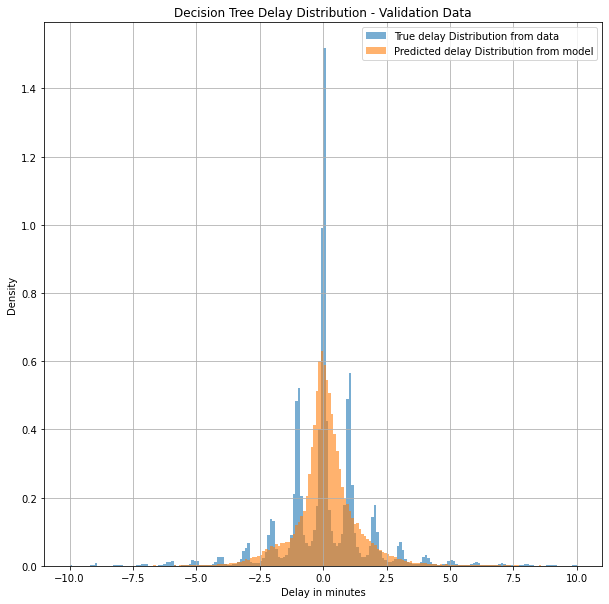

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(y_val_1[abs(y_val_1['delay_minutes_updated'])<10]['delay_minutes_updated'],bins = 200,alpha = 0.6,density=True, label='True delay Distribution from data')
plt.hist(y_val_preds[abs(y_val_preds) < 10], bins = 200,alpha = 0.6, density=True, label='Predicted delay Distribution from model')
plt.xlabel('Delay in minutes')
plt.ylabel('Density')
plt.title('Decision Tree Delay Distribution - Validation Data')
plt.legend()
plt.grid()
plt.plot()

### Below we plot the feature importance returned by the decision tree classifier.

In [ ]:
dt_model.feature_importances_

array([0.07350916, 0.16285576, 0.08545375, 0.16473531, 0.03830773,
       0.02945522, 0.01742133, 0.00526972, 0.00608607, 0.03192345,
       0.03764826, 0.03105426, 0.03237421, 0.01366136, 0.03649228,
       0.03124064, 0.02598764, 0.00517687, 0.00602475, 0.04031617,
       0.04337125, 0.0307739 , 0.0357694 , 0.01509151])

In [ ]:
feature_importance_df = pd.DataFrame({'features': X_train_1.columns.tolist(), 'feature_importance': dt_model.feature_importances_})

In [ ]:
feature_importance_df = feature_importance_df.sort_values(by='feature_importance')

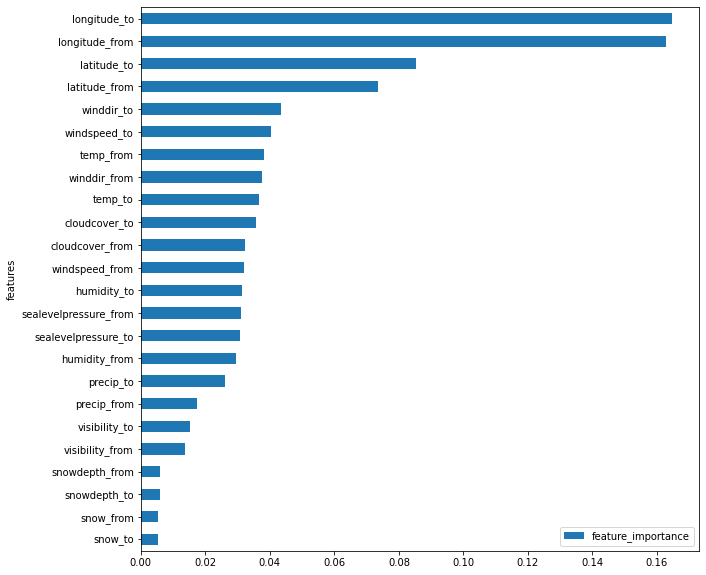

In [ ]:
feature_importance_df.plot(x='features', y='feature_importance', kind='barh', figsize=(10, 10))

We observe that the location of the stations are important for prediticing the delays along with certain weather features like wind parameters, temeratures etc. Surprinsgly the parameters related to snow are not deemed important.


This supports our original hypothesis that the weather data is relevant for understanding and predicting train delays.

## 3.5 XGBoost

We will try a XGBoost model to see if it performs better. We were not able to use Randomn Forests due to lack of compute to run ensemble methods on such a large amount of data.

In [ ]:
xgb_reg_2 = xg.XGBRegressor(max_depth = 6)
xgb_reg_2.fit(X_train_1, y_train_1, eval_set = [(X_val, y_val)])

[01:06:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.66203
[1]	validation_0-rmse:2.64344
[2]	validation_0-rmse:2.62859
[3]	validation_0-rmse:2.61426
[4]	validation_0-rmse:2.60314
[5]	validation_0-rmse:2.59484
[6]	validation_0-rmse:2.58855
[7]	validation_0-rmse:2.58047
[8]	validation_0-rmse:2.57422
[9]	validation_0-rmse:2.57022
[10]	validation_0-rmse:2.56478
[11]	validation_0-rmse:2.56122
[12]	validation_0-rmse:2.55671
[13]	validation_0-rmse:2.55274
[14]	validation_0-rmse:2.54964
[15]	validation_0-rmse:2.54703
[16]	validation_0-rmse:2.54448
[17]	validation_0-rmse:2.5415
[18]	validation_0-rmse:2.53706
[19]	validation_0-rmse:2.53195
[20]	validation_0-rmse:2.52989
[21]	validation_0-rmse:2.52684
[22]	validation_0-rmse:2.52418
[23]	validation_0-rmse:2.52283
[24]	validation_0-rmse:2.52036
[25]	validation_0-rmse:2.51844
[26]	validation_0-rmse:2.5171
[27]	validation_0-rmse:2.51362
[28]	validation_0

XGBRegressor(max_depth=6)

In [ ]:
y_train_1_preds = xgb_reg_2.predict(X_train_1)
y_test_1_preds = xgb_reg_2.predict(X_test_1)

In [ ]:
print('----------------------------------------------------------')
print('Train Metrics: ')
print(f'r2 score:  {r2_score(y_train_2, y_train_1_preds)}')
print(f'mse score: {mean_squared_error(y_train_1, y_train_1_preds)}')
print(f'mae score: {mean_absolute_error(y_train_1, y_train_1_preds)}')
print('----------------------------------------------------------')
print('Test Metrics: ')
print(f'r2 score:  {r2_score(y_test_1, y_test_1_preds)}')
print(f'mse score: {mean_squared_error(y_test_1, y_test_1_preds)}')
print(f'mae score: {mean_absolute_error(y_test_1, y_test_1_preds)}')

----------------------------------------------------------
Train Metrics: 
r2 score:  0.14994375299618445
mse score: 6.028849851508745
mae score: 1.132884023707732
----------------------------------------------------------
Test Metrics: 
r2 score:  0.14024697078785808
mse score: 5.988181585360793
mae score: 1.1373005603935793


XGBoost returns the best performace over all the above models. But the model performace is not satifactory.

### Distributions

From The below distribution we can see that even a boosting model has learnt a distribution similar to a normal distrbuition ans is not able to capture the true distribution of the labels from the training data.

[]

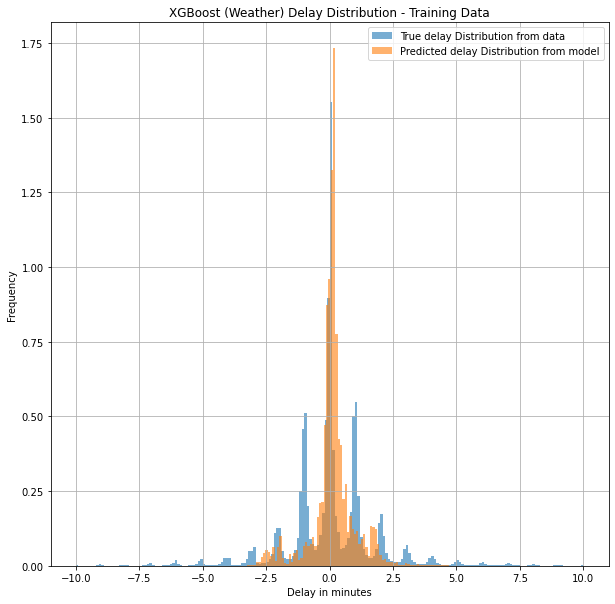

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(y_train_1[abs(y_train_1)<10], bins = 200, alpha = 0.6, density=True,
         label='True delay Distribution from data')
plt.hist(y_train_2_preds[abs(y_train_1_preds) < 10], bins = 200, alpha = 0.6, density=True,
         label='Predicted delay Distribution from model')
plt.xlabel('Delay in minutes')
plt.ylabel('Frequency')
plt.title('XGBoost (Weather) Delay Distribution - Training Data')
plt.legend()
plt.grid()
plt.plot()

## 3.6 Neural Nets

MLP architecture was tried to model the complex relation between the data and the label. 

But the models did not yield expected results.

In [ ]:
class TrainWeatherDataset(Dataset):
    def __init__(self, data_df, labels_df):
        '''
        inputs:
        data_df: imput features pandas dataframe
        labels_df: labels pandas dataframe
        '''
        super(TrainWeatherDataset, self).__init__()
        
        self.data_df = data_df
        self.labels_df = labels_df

        return

    def __getitem__(self, index):
        
        x = torch.Tensor(self.data_df.iloc[index])
        y = torch.Tensor(self.labels_df.iloc[index])


        return x, y

    def __len__(self):
        return len(self.labels_df)


In [ ]:
train_dataset = TrainWeatherDataset(X_train_1, y_train_1)
val_dataset = TrainWeatherDataset(X_val_1, y_val_1)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [ ]:
class TrainsWeatherMLP(nn.Module):

    def __init__(self, input_features_size):
        super(TrainsWeatherMLP, self).__init__()

        self.mlp = nn.Sequential(nn.Linear(in_features=input_features_size, out_features=256),
                                 nn.ReLU(),
                                 nn.Linear(in_features=256, out_features=128),
                                 nn.ReLU(),
                                 nn.Linear(in_features=128, out_features=64),
                                 nn.ReLU(),
                                 nn.Linear(in_features=64, out_features=32),
                                 nn.ReLU(),
                                 nn.Linear(in_features=32, out_features=16),
                                 nn.ReLU(),
                                 nn.Linear(in_features=16, out_features=4),
                                 nn.ReLU(),
                                 nn.Linear(in_features=4, out_features=1),
                                 )
        
    def forward(self, x):
        
        x = self.mlp(x)

        return x

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda:0'

In [ ]:
nn_reg = TrainsWeatherMLP(len(X_train_1.columns)).to(device)

optimizer = optim.Adam(nn_reg.parameters(), lr=1e-4)
epochs = 2
criterion = nn.MSELoss()

train_loss_epochs = []
train_loss_steps = []
val_loss_epochs = []
val_loss_steps = []

y_train_preds = []
y_train_labels = []
y_val_preds = []
y_val_labels = []

for t in tqdm(range(epochs)):

    running_loss = 0.0
    num_batches = 0

    y_train_preds.clear()
    y_train_labels.clear()

    nn_reg.train()
    for idx, batch in enumerate(train_dataloader):

        x = batch[0].to(device)
        labels = batch[1].to(device)

        preds = nn_reg(x)

        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.detach().cpu().item()
        num_batches += 1
        y_train_preds.extend(preds.detach().cpu().numpy().tolist())
        y_train_labels.extend(labels.detach().cpu().numpy().tolist())
        train_loss_steps.append(loss.detach().cpu().item())


    train_loss_epochs.append(running_loss / num_batches)
    print(f'\nepoch {t}, train_loss={train_loss_epochs[-1]}')


    y_val_preds.clear()
    y_val_labels.clear()
    
    num_val_batches = 0
    running_val_loss = 0

    nn_reg.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_dataloader):

            x = batch[0].to(device)
            labels = batch[1].to(device)

            preds = nn_reg(x)

            loss = criterion(preds, labels)


            running_val_loss += loss.detach().cpu().item()
            num_val_batches += 1
            y_val_preds.extend(preds.detach().cpu().numpy().tolist())
            y_val_labels.extend(labels.detach().cpu().numpy().tolist())
            val_loss_steps.append(loss.detach().cpu().item())


        val_loss_epochs.append(running_val_loss / num_val_batches)
        print(f'\nepoch {t}, val_loss={val_loss_epochs[-1]}')


  0%|          | 0/2 [00:00<?, ?it/s]


epoch 0, train_loss=7.1007302971644695


 50%|█████     | 1/2 [07:03<07:03, 423.51s/it]


epoch 0, val_loss=7.074457519315447

epoch 1, train_loss=7.09229776100065


100%|██████████| 2/2 [14:21<00:00, 430.53s/it]


epoch 1, val_loss=7.074338113940961


## 3.7 Predict delay without weather data

We also try delay prediction without using weather data to see if weather data is adding noise to the original NJ_transit trains data to make the predictions difficult.


We use a XG boost model for this task.

In [ ]:
X_0 = train_weather_df[['latitude_from', 'longitude_from',
                                 'latitude_to', 'longitude_to']]

In [ ]:
months_df = pd.get_dummies(pd.to_datetime(train_weather_df['date']).dt.month, prefix="month")
lines_df = pd.get_dummies(train_weather_df['line'], prefix="line")

In [ ]:
X_0 = pd.concat([X_0,months_df,lines_df],axis=1)

In [ ]:
X_train, X_test_0, y_train, y_test_0 = train_test_split(X_0, y['delay_minutes_updated'],
                      test_size = 0.2, random_state = 42)
X_train_0, X_val, y_train_0, y_val = train_test_split(X_train,y_train,
                                                  random_state=42, 
                                                  test_size=0.25)

Text(0.5, 1.0, 'Correlations For Non-Weather Dataset')

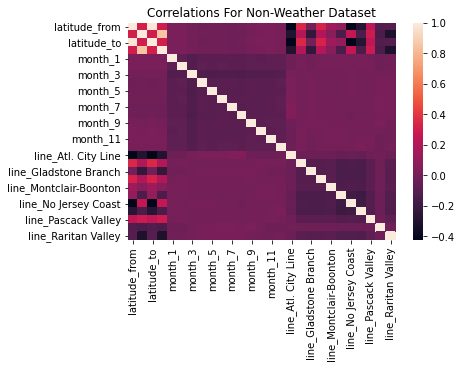

In [ ]:
sns.heatmap(X_0.corr())
plt.title('Correlations For Non-Weather Dataset')

In [ ]:
xgb_reg_0 = xg.XGBRegressor(n_estimators = 100,
                            max_depth = 6)
xgb_reg_0.fit(X_train_0, y_train_0,
              eval_set = [(X_val, y_val)])

[00:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.66192
[1]	validation_0-rmse:2.64317
[2]	validation_0-rmse:2.62809
[3]	validation_0-rmse:2.61371
[4]	validation_0-rmse:2.60265
[5]	validation_0-rmse:2.59433
[6]	validation_0-rmse:2.58553
[7]	validation_0-rmse:2.58
[8]	validation_0-rmse:2.57388
[9]	validation_0-rmse:2.57
[10]	validation_0-rmse:2.56424
[11]	validation_0-rmse:2.55938
[12]	validation_0-rmse:2.55546
[13]	validation_0-rmse:2.55168
[14]	validation_0-rmse:2.5486
[15]	validation_0-rmse:2.54534
[16]	validation_0-rmse:2.54238
[17]	validation_0-rmse:2.53829
[18]	validation_0-rmse:2.53656
[19]	validation_0-rmse:2.53447
[20]	validation_0-rmse:2.53183
[21]	validation_0-rmse:2.52865
[22]	validation_0-rmse:2.52686
[23]	validation_0-rmse:2.52492
[24]	validation_0-rmse:2.52405
[25]	validation_0-rmse:2.52308
[26]	validation_0-rmse:2.5214
[27]	validation_0-rmse:2.51867
[28]	validation_0-rmse:

XGBRegressor(max_depth=6)

In [ ]:
y_train_0_preds = xgb_reg_0.predict(X_train_0)
y_test_0_preds = xgb_reg_0.predict(X_test_0)

In [ ]:
print('----------------------------------------------------------')
print('Train Metrics: ')
print(f'r2 score:  {r2_score(y_train_0, y_train_0_preds)}')
print(f'mse score: {mean_squared_error(y_train_0, y_train_0_preds)}')
print(f'mae score: {mean_absolute_error(y_train_0, y_train_0_preds)}')
print('----------------------------------------------------------')
print('Test Metrics: ')
print(f'r2 score:  {r2_score(y_test_0, y_test_0_preds)}')
print(f'mse score: {mean_squared_error(y_test_0, y_test_0_preds)}')
print(f'mae score: {mean_absolute_error(y_test_0, y_test_0_preds)}')

----------------------------------------------------------
Train Metrics: 
r2 score:  0.1436876585074348
mse score: 6.073219920504137
mae score: 1.1242229698034651
----------------------------------------------------------
Test Metrics: 
r2 score:  0.14494431409641217
mse score: 5.955464579727003
mae score: 1.1267391810985279


We observe that the model performance with and without weather data is similar.

Since the model is still poor, we cannot infer that weather data is adding noise to the original data. Instead we can infer that the prediction task is quite difficult due to the nature of the data and requires much more complex methods to tabkle the task at hand.

### Distribution

The distribution of the predictions for without weather data is also similar to the distributions with the weather data

[]

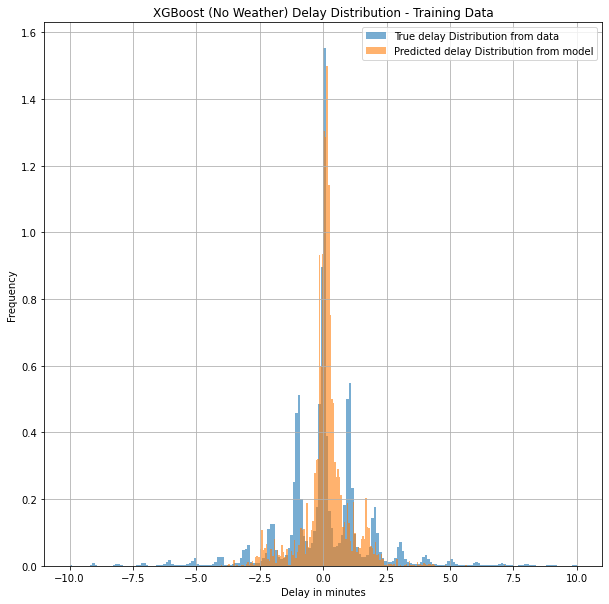

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(y_train_0[abs(y_train_0)<10], bins = 200, alpha = 0.6, density=True,
         label='True delay Distribution from data')
plt.hist(y_train_0_preds[abs(y_train_0_preds) < 10], bins = 200, alpha = 0.6, density=True,
         label='Predicted delay Distribution from model')
plt.xlabel('Delay in minutes')
plt.ylabel('Frequency')
plt.title('XGBoost (No Weather) Delay Distribution - Training Data')
plt.legend()
plt.grid()
plt.plot()

# 4. Conclusion & Future Scope

[]

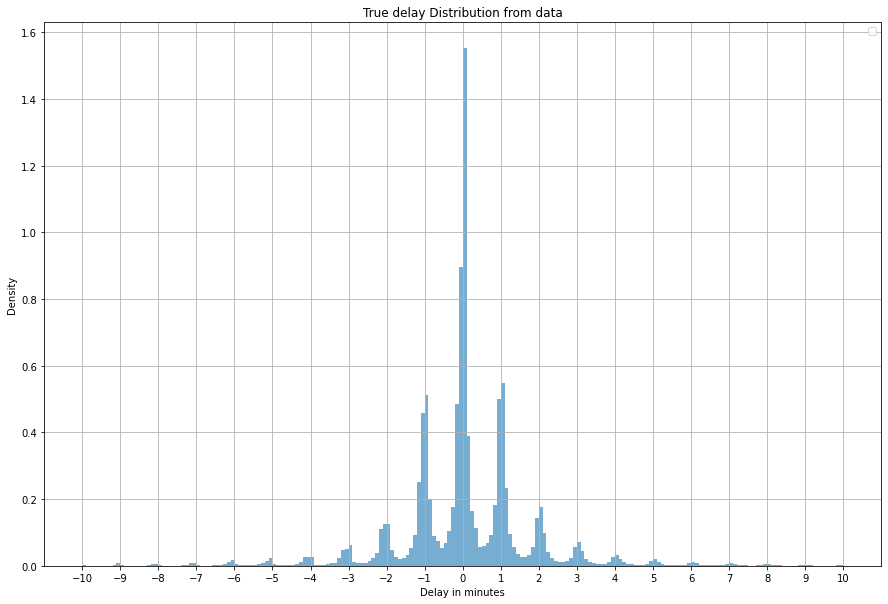

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(y_train_1[abs(y_train_1['delay_minutes_updated'])<10]['delay_minutes_updated'],bins = 200, alpha = 0.6,density=True)
plt.xlabel('Delay in minutes')
plt.ylabel('Density')
plt.title('True delay Distribution from data')
plt.xticks(np.arange(-10, 11))
plt.legend()
plt.grid()
plt.plot()

<br>
EDA:

Conducting EDA on our dataset was a highly fruitful task which gave us insights into correlations even before modelling could be conducted.

<br>
The Dataset: 

We observed a peculiar distribution for the delay labels. From the above, we can gather that most trains are somehow only arriving at a station in the first half of a minute - indicated by the peak after almost every integer, and a dip close to the 0.5 marks. We observed that most of the machine learning models we used are not able to capture the exact distribution and instead fit a function which approximates a normal distribution.

<br>
Modelling: 

This indicates that the family of models used (Linear Models, Decicision Trees etc.) are not adequate for the task.
XGBoost was the best predictor from all of the above, although still giving a poor performance overall. The reason for its performance could be due to the fact that it is a highly optimized regressor that can combine multiple learners.

<br>
Future Work: 

For the distribution observed a model like a mixture of gaussians or mixture of f-distributions might be ideal. These family of models should produce better results as they would better capture the inherent nature of the output distribution along with the relation between the input data and the predicted label. These models were not tried due to time constraints and as they are out of scope for this course.

Further, we planned on building a graph of the rail network and using the above delay prediction model to suggest the best path possible considering the delays associated with weather. A model like this could be extremely beneficial for travellers looking to plan a multi-train trip. With more accurate modelling solutions, this can be readily achieved through graph algorithms like Breadth-First Search.


# References


*   Train Data Source: [NJ transit](https://www.kaggle.com/datasets/pranavbadami/nj-transit-amtrak-nec-performance)
*   Weather Data Source: [Visual Crossing](https://visualcrossing.com/)
*   Pu Wang, Qing-peng Zhang, Train delay analysis and prediction based on big data fusion, Transportation Safety and Environment, Volume 1, Issue 1, 1 July 2019, Pages 79–88, (https://doi.org/10.1093/tse/tdy001)
*   Garani, G.; Papadatos, D.; Kotsiantis, S.; Verykios, V.S. Meteorological Data Warehousing and Analysis for Supporting Air Navigation. Informatics 2022, 9, 78. (https://doi.org/10.3390/informatics9040078)
*   S. Choi, Y. J. Kim, S. Briceno and D. Mavris, "Prediction of weather-induced airline delays based on machine learning algorithms," 2016 IEEE/AIAA 35th Digital Avionics Systems Conference (DASC), 2016, pp. 1-6, doi: 10.1109/DASC.2016.7777956
*   	Exploring the impact of weather on Metro demand forecasting using machine learning methods, arXiv:2210.13965
*     N. L. Kalyani, G. Jeshmitha, B. S. Sai U., M. Samanvitha, J. Mahesh and B. V. Kiranmayee, "Machine Learning Model - based Prediction of Flight Delay," 2020 Fourth International Conference on I-SMAC (IoT in Social, Mobile, Analytics and Cloud) (I-SMAC), 2020, pp. 577-581, doi: 10.1109/I-SMAC49090.2020.9243339.

